In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 5
patience_teacher = 20
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [10,5,3,0]
lmda_list_teacher = [10,5,3,0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
# SPECIFY OUT DIR NAME
output_dir = 'RUN'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

In [12]:
def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break

        # Extract labels from the batch
        labels = batch['label']

        # Count occurrences of each class
        class_counts = torch.bincount(labels)

        # Map class counts to class names
        class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

        # Print class counts and total observations
        print(f"Batch {i + 1}:")
        for class_name, count in class_counts_with_names.items():
            print(f"    {class_name}: {count}")
        print(f"Total Observations: {len(labels)}\n")

print_batch_class_counts(trainloader, new_label_mapping)


Batch 1:
    Team_Sports: 13
    Celebration: 9
    Parade: 7
    Waiter_Or_Waitress: 1
    Individual_Sports: 6
    Surgeons: 1
    Spa: 1
    Law_Enforcement: 4
    Business: 2
    Dresses: 5
    Water_Activities: 1
    Picnic: 4
    Rescue: 1
    Cheering: 3
    Performance_And_Entertainment: 2
    Family: 4
Total Observations: 64

Batch 2:
    Team_Sports: 12
    Celebration: 7
    Parade: 5
    Waiter_Or_Waitress: 3
    Individual_Sports: 5
    Surgeons: 2
    Spa: 0
    Law_Enforcement: 7
    Business: 2
    Dresses: 4
    Water_Activities: 3
    Picnic: 1
    Rescue: 2
    Cheering: 0
    Performance_And_Entertainment: 7
    Family: 4
Total Observations: 64

Batch 3:
    Team_Sports: 18
    Celebration: 3
    Parade: 3
    Waiter_Or_Waitress: 3
    Individual_Sports: 6
    Surgeons: 2
    Spa: 0
    Law_Enforcement: 3
    Business: 3
    Dresses: 0
    Water_Activities: 5
    Picnic: 0
    Rescue: 3
    Cheering: 7
    Performance_And_Entertainment: 2
    Family: 6
Total Observa

# Start Training Process

In [13]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [14]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights=None)
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [15]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [16]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [18]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [19]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [20]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [21]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [22]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [23]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [24]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [25]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_wider_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_wider_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Student Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nStudent Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 1/300*****
*****Train Loss:  1.580980 Val Loss:  1.298615*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.1686773766401768*****

Class Team_Sports: Recall Difference = 0.12571962398551983
Class Celebration: Recall Difference = 0.025581395348837244
Class Parade: Recall Difference = 0.038722554890219585
Class Waiter_Or_Waitress: Recall Difference = -0.005085529357374052
Class Individual_Sports: Recall Difference = -0.14652430713312126
Class Surgeons: Recall Difference = -0.0694752402069474
Class Spa: Recall Difference = -0.9199999999999999
Class Law_Enforcement: Recall Difference = 0.1233733733733734
Class Business: Recall Difference = -0.042035634268643984
Class Dresses: Recall Difference = -0.7500000000000001
Class Water_Activities: Recall Difference = 0.07686486486486488
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.002531645569620239
Class Cheering: Recall Difference = -0.05988515176374079
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 2/300*****
*****Train Loss:  0.990937 Val Loss:  1.242742*****
*****Validation Accuracy: 63.98%*****
*****Total Avg Disparity: 0.17562652056428585*****

Class Team_Sports: Recall Difference = 0.12510071816430202
Class Celebration: Recall Difference = -0.009302325581395265
Class Parade: Recall Difference = 0.10322212717422286
Class Waiter_Or_Waitress: Recall Difference = -0.1030975496994917
Class Individual_Sports: Recall Difference = -0.07648038770255938
Class Surgeons: Recall Difference = -0.03252032520325199
Class Spa: Recall Difference = -0.86
Class Law_Enforcement: Recall Difference = 0.126876876876877
Class Business: Recall Difference = -0.058145737757388294
Class Dresses: Recall Difference = -0.7743902439024392
Class Water_Activities: Recall Difference = 0.054270270270270315
Class Picnic: Recall Difference = -0.12727272727272737
Class Rescue: Recall Difference = 0.032405063291139236
Class Cheering: Recall Difference = 0.029327317473338776
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 3/300*****
*****Train Loss:  0.617632 Val Loss:  1.414852*****
*****Validation Accuracy: 60.03%*****
*****Total Avg Disparity: 0.16118043041350738*****

Class Team_Sports: Recall Difference = 0.06757750919600636
Class Celebration: Recall Difference = 0.041860465116279055
Class Parade: Recall Difference = -0.005360707157114453
Class Waiter_Or_Waitress: Recall Difference = -0.17337031900138694
Class Individual_Sports: Recall Difference = -0.10767832803271249
Class Surgeons: Recall Difference = -0.10051736881005174
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.0695695695695695
Class Business: Recall Difference = -0.06785447562146585
Class Dresses: Recall Difference = -0.7621951219512196
Class Water_Activities: Recall Difference = 0.12486486486486492
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = -0.002278481012658262
Class Cheering: Recall Difference = -0.04163248564397054
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 4/300*****
*****Train Loss:  0.382789 Val Loss:  1.594939*****
*****Validation Accuracy: 61.07%*****
*****Total Avg Disparity: 0.14695907561924082*****

Class Team_Sports: Recall Difference = 0.029754189291761546
Class Celebration: Recall Difference = -0.034883720930232565
Class Parade: Recall Difference = -0.018135158254918737
Class Waiter_Or_Waitress: Recall Difference = 0.005547850208044269
Class Individual_Sports: Recall Difference = -0.0021581099500226353
Class Surgeons: Recall Difference = -0.10716925351071688
Class Spa: Recall Difference = -0.84
Class Law_Enforcement: Recall Difference = 0.08133133133133141
Class Business: Recall Difference = -0.06785447562146596
Class Dresses: Recall Difference = -0.6890243902439026
Class Water_Activities: Recall Difference = 0.15243243243243243
Class Picnic: Recall Difference = 0.1454545454545454
Class Rescue: Recall Difference = -0.004303797468354464
Class Cheering: Recall Difference = -0.04060705496308448
Class Performance_And_Ent

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 5/300*****
*****Train Loss:  0.289762 Val Loss:  1.735581*****
*****Validation Accuracy: 61.07%*****
*****Total Avg Disparity: 0.16936949594270093*****

Class Team_Sports: Recall Difference = 0.07229520639925258
Class Celebration: Recall Difference = 0.034883720930232565
Class Parade: Recall Difference = 0.04009124607926984
Class Waiter_Or_Waitress: Recall Difference = 0.005547850208044269
Class Individual_Sports: Recall Difference = -0.1409965167348176
Class Surgeons: Recall Difference = -0.14264597191426454
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.13013013013013008
Class Business: Recall Difference = -0.13197482129520954
Class Dresses: Recall Difference = -0.8658536585365856
Class Water_Activities: Recall Difference = 0.03275675675675682
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = -0.020253164556962022
Class Cheering: Recall Difference = 0.10849056603773588
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 6/300*****
*****Train Loss:  0.234739 Val Loss:  1.855833*****
*****Validation Accuracy: 60.61%*****
*****Total Avg Disparity: 0.1505758546915607*****

Class Team_Sports: Recall Difference = 0.08581771471944888
Class Celebration: Recall Difference = -0.023255813953488413
Class Parade: Recall Difference = 0.034388366124893044
Class Waiter_Or_Waitress: Recall Difference = -0.13037447988904305
Class Individual_Sports: Recall Difference = 0.008405270331667491
Class Surgeons: Recall Difference = -0.09977827050997767
Class Spa: Recall Difference = -0.7799999999999999
Class Law_Enforcement: Recall Difference = 0.20795795795795813
Class Business: Recall Difference = 0.006294676197588778
Class Dresses: Recall Difference = -0.6023035230352303
Class Water_Activities: Recall Difference = 0.052324324324324434
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = -0.10683544303797471
Class Cheering: Recall Difference = 0.004101722723543921
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 7/300*****
*****Train Loss:  0.179357 Val Loss:  1.918015*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.18363284938749605*****

Class Team_Sports: Recall Difference = 0.06993635779762919
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.0626746506986029
Class Waiter_Or_Waitress: Recall Difference = -0.014794267221451829
Class Individual_Sports: Recall Difference = -0.0696274420717855
Class Surgeons: Recall Difference = -0.0761271249076127
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.15065065065065075
Class Business: Recall Difference = -0.1209858103061987
Class Dresses: Recall Difference = -0.6327913279132793
Class Water_Activities: Recall Difference = 0.10691891891891891
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.026835443037974638
Class Cheering: Recall Difference = -0.016201804757998373
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 8/300*****
*****Train Loss:  0.135687 Val Loss:  2.030747*****
*****Validation Accuracy: 58.96%*****
*****Total Avg Disparity: 0.1470707151536908*****

Class Team_Sports: Recall Difference = 0.05349448239621646
Class Celebration: Recall Difference = 0.07209302325581401
Class Parade: Recall Difference = 0.04990019960079828
Class Waiter_Or_Waitress: Recall Difference = -0.02357836338418884
Class Individual_Sports: Recall Difference = -0.11396334999242752
Class Surgeons: Recall Difference = 0.04582409460458259
Class Spa: Recall Difference = -0.5599999999999999
Class Law_Enforcement: Recall Difference = 0.09459459459459463
Class Business: Recall Difference = -0.18766670222980908
Class Dresses: Recall Difference = -0.49119241192411933
Class Water_Activities: Recall Difference = 0.12789189189189187
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.11772151898734179
Class Cheering: Recall Difference = 0.020098441345365092
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 9/300*****
*****Train Loss:  0.132379 Val Loss:  2.143229*****
*****Validation Accuracy: 60.20%*****
*****Total Avg Disparity: 0.1564105580180079*****

Class Team_Sports: Recall Difference = 0.03895603433175676
Class Celebration: Recall Difference = 0.08837209302325577
Class Parade: Recall Difference = 0.01670943826632454
Class Waiter_Or_Waitress: Recall Difference = -0.0420711974110034
Class Individual_Sports: Recall Difference = -0.05944267757080124
Class Surgeons: Recall Difference = 0.05691056910569103
Class Spa: Recall Difference = -0.7599999999999999
Class Law_Enforcement: Recall Difference = 0.023773773773773876
Class Business: Recall Difference = -0.12941427504534297
Class Dresses: Recall Difference = -0.48509485094850957
Class Water_Activities: Recall Difference = 0.11189189189189197
Class Picnic: Recall Difference = -0.4363636363636364
Class Rescue: Recall Difference = -0.024303797468354482
Class Cheering: Recall Difference = 0.024405250205086104
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 10/300*****
*****Train Loss:  0.143743 Val Loss:  2.029159*****
*****Validation Accuracy: 60.52%*****
*****Total Avg Disparity: 0.18766633208595387*****

Class Team_Sports: Recall Difference = 0.01449173819116012
Class Celebration: Recall Difference = 0.06744186046511635
Class Parade: Recall Difference = 0.11901910464784715
Class Waiter_Or_Waitress: Recall Difference = 0.08136846971798428
Class Individual_Sports: Recall Difference = -0.10483870967741937
Class Surgeons: Recall Difference = -0.09977827050997767
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.14189189189189189
Class Business: Recall Difference = -0.1209858103061986
Class Dresses: Recall Difference = -0.4972899728997291
Class Water_Activities: Recall Difference = 0.15740540540540537
Class Picnic: Recall Difference = -0.4181818181818182
Class Rescue: Recall Difference = 0.11037974683544305
Class Cheering: Recall Difference = -0.06911402789171456
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 11/300*****
*****Train Loss:  0.134230 Val Loss:  2.252826*****
*****Validation Accuracy: 59.71%*****
*****Total Avg Disparity: 0.13633823541574644*****

Class Team_Sports: Recall Difference = 0.07571670461843871
Class Celebration: Recall Difference = -0.03023255813953496
Class Parade: Recall Difference = 0.057770173937838676
Class Waiter_Or_Waitress: Recall Difference = -0.1470180305131762
Class Individual_Sports: Recall Difference = -0.10521732545812512
Class Surgeons: Recall Difference = 0.03252032520325199
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.07557557557557565
Class Business: Recall Difference = -0.13762936093033185
Class Dresses: Recall Difference = -0.43631436314363137
Class Water_Activities: Recall Difference = 0.09535135135135142
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = 0.016455696202531678
Class Cheering: Recall Difference = 0.020098441345365148
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 12/300*****
*****Train Loss:  0.142425 Val Loss:  2.122947*****
*****Validation Accuracy: 62.16%*****
*****Total Avg Disparity: 0.1685185375083107*****

Class Team_Sports: Recall Difference = 0.050516727973375475
Class Celebration: Recall Difference = 0.11162790697674418
Class Parade: Recall Difference = 0.0036498431708013035
Class Waiter_Or_Waitress: Recall Difference = -0.10032362459546951
Class Individual_Sports: Recall Difference = -0.08465848856580327
Class Surgeons: Recall Difference = 0.14264597191426454
Class Spa: Recall Difference = -0.68
Class Law_Enforcement: Recall Difference = 0.037537537537537524
Class Business: Recall Difference = -0.08471140509975461
Class Dresses: Recall Difference = -0.7256097560975611
Class Water_Activities: Recall Difference = 0.05232432432432432
Class Picnic: Recall Difference = 0.1454545454545454
Class Rescue: Recall Difference = 0.05569620253164542
Class Cheering: Recall Difference = -0.03937653814602138
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 13/300*****
*****Train Loss:  0.101784 Val Loss:  2.185696*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.1399808302488127*****

Class Team_Sports: Recall Difference = 0.08087814561802997
Class Celebration: Recall Difference = 0.039534883720930336
Class Parade: Recall Difference = 0.015340747077274064
Class Waiter_Or_Waitress: Recall Difference = -0.10818307905686553
Class Individual_Sports: Recall Difference = -0.09484325306678776
Class Surgeons: Recall Difference = 0.026607538802660757
Class Spa: Recall Difference = -0.49999999999999994
Class Law_Enforcement: Recall Difference = 0.0563063063063064
Class Business: Recall Difference = -0.13378854155553188
Class Dresses: Recall Difference = -0.7059620596205964
Class Water_Activities: Recall Difference = 0.07243243243243258
Class Picnic: Recall Difference = 0.018181818181818077
Class Rescue: Recall Difference = 0.009113924050632882
Class Cheering: Recall Difference = -0.009639048400328143
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 14/300*****
*****Train Loss:  0.097001 Val Loss:  2.120974*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.16724225192128722*****

Class Team_Sports: Recall Difference = 0.10355578910492202
Class Celebration: Recall Difference = -0.0674418604651163
Class Parade: Recall Difference = 0.032221271742229884
Class Waiter_Or_Waitress: Recall Difference = -0.005085529357374052
Class Individual_Sports: Recall Difference = -0.07924428290171148
Class Surgeons: Recall Difference = 0.0088691796008869
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.09659659659659658
Class Business: Recall Difference = -0.0808705857249547
Class Dresses: Recall Difference = -0.7195121951219512
Class Water_Activities: Recall Difference = 0.14691891891891895
Class Picnic: Recall Difference = -0.27272727272727276
Class Rescue: Recall Difference = 0.0037974683544304
Class Cheering: Recall Difference = -0.09351927809680072
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 15/300*****
*****Train Loss:  0.098197 Val Loss:  2.260119*****
*****Validation Accuracy: 61.13%*****
*****Total Avg Disparity: 0.17237164287926068*****

Class Team_Sports: Recall Difference = 0.0684766742570212
Class Celebration: Recall Difference = 0.030232558139534904
Class Parade: Recall Difference = 0.05018534359851723
Class Waiter_Or_Waitress: Recall Difference = -0.14008321775312083
Class Individual_Sports: Recall Difference = -0.07258064516129026
Class Surgeons: Recall Difference = -0.1359940872135993
Class Spa: Recall Difference = -0.6199999999999999
Class Law_Enforcement: Recall Difference = 0.17567567567567555
Class Business: Recall Difference = -0.07244212098581027
Class Dresses: Recall Difference = -0.4789972899728997
Class Water_Activities: Recall Difference = 0.1554594594594596
Class Picnic: Recall Difference = -0.2181818181818182
Class Rescue: Recall Difference = 0.043037974683544256
Class Cheering: Recall Difference = 0.020098441345365037
Class Performance_A

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 16/300*****
*****Train Loss:  0.080438 Val Loss:  2.347148*****
*****Validation Accuracy: 60.32%*****
*****Total Avg Disparity: 0.1723810848565014*****

Class Team_Sports: Recall Difference = 0.04939569101418795
Class Celebration: Recall Difference = 0.02093023255813964
Class Parade: Recall Difference = 0.053150841174793184
Class Waiter_Or_Waitress: Recall Difference = -0.17799352750809083
Class Individual_Sports: Recall Difference = -0.11188096319854612
Class Surgeons: Recall Difference = -0.14929785661492972
Class Spa: Recall Difference = -0.6799999999999999
Class Law_Enforcement: Recall Difference = 0.14864864864864857
Class Business: Recall Difference = -0.12610690280593184
Class Dresses: Recall Difference = -0.5779132791327914
Class Water_Activities: Recall Difference = 0.1689729729729731
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.08911392405063293
Class Cheering: Recall Difference = -0.0459392945036915
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 17/300*****
*****Train Loss:  0.069146 Val Loss:  2.285361*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.18175000647856013*****

Class Team_Sports: Recall Difference = 0.13121971156653245
Class Celebration: Recall Difference = 0.0790697674418605
Class Parade: Recall Difference = 0.053150841174793295
Class Waiter_Or_Waitress: Recall Difference = -0.11974110032362473
Class Individual_Sports: Recall Difference = -0.08742238376495526
Class Surgeons: Recall Difference = -0.027346637102734606
Class Spa: Recall Difference = -0.7
Class Law_Enforcement: Recall Difference = 0.11661661661661682
Class Business: Recall Difference = -0.0816174117144991
Class Dresses: Recall Difference = -0.7439024390243902
Class Water_Activities: Recall Difference = 0.084864864864865
Class Picnic: Recall Difference = -0.12727272727272726
Class Rescue: Recall Difference = 0.08708860759493675
Class Cheering: Recall Difference = -0.0545529122231338
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 18/300*****
*****Train Loss:  0.100945 Val Loss:  2.330252*****
*****Validation Accuracy: 60.38%*****
*****Total Avg Disparity: 0.16267139302365308*****

Class Team_Sports: Recall Difference = 0.11185846908390262
Class Celebration: Recall Difference = 0.04418604651162794
Class Parade: Recall Difference = 0.06541203307670374
Class Waiter_Or_Waitress: Recall Difference = -0.16643550624133152
Class Individual_Sports: Recall Difference = -0.07000605785249148
Class Surgeons: Recall Difference = -0.05173688100517371
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.1251251251251253
Class Business: Recall Difference = -0.07169529499626592
Class Dresses: Recall Difference = -0.60840108401084
Class Water_Activities: Recall Difference = 0.17091891891891897
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.013164556962025342
Class Cheering: Recall Difference = -0.05024610336341262
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 19/300*****
*****Train Loss:  0.100941 Val Loss:  2.198342*****
*****Validation Accuracy: 61.82%*****
*****Total Avg Disparity: 0.15667465256719246*****

Class Team_Sports: Recall Difference = 0.09243883925964858
Class Celebration: Recall Difference = 0.05581395348837204
Class Parade: Recall Difference = 0.04009124607927006
Class Waiter_Or_Waitress: Recall Difference = -0.18862690707350915
Class Individual_Sports: Recall Difference = -0.05497501135847338
Class Surgeons: Recall Difference = -0.08203991130820387
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.10835835835835839
Class Business: Recall Difference = -0.12098581030619865
Class Dresses: Recall Difference = -0.5779132791327914
Class Water_Activities: Recall Difference = 0.06691891891891888
Class Picnic: Recall Difference = -0.16363636363636366
Class Rescue: Recall Difference = 0.061772151898734196
Class Cheering: Recall Difference = -0.013330598851517661
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 20/300*****
*****Train Loss:  0.098377 Val Loss:  2.310764*****
*****Validation Accuracy: 59.22%*****
*****Total Avg Disparity: 0.161167069800054*****

Class Team_Sports: Recall Difference = 0.08413615928066798
Class Celebration: Recall Difference = 0.07441860465116273
Class Parade: Recall Difference = 0.04607927003136569
Class Waiter_Or_Waitress: Recall Difference = -0.08876560332871009
Class Individual_Sports: Recall Difference = -0.06743147054369225
Class Surgeons: Recall Difference = -0.04508499630450835
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.13513513513513514
Class Business: Recall Difference = -0.09570041608876573
Class Dresses: Recall Difference = -0.6693766937669376
Class Water_Activities: Recall Difference = 0.12097297297297294
Class Picnic: Recall Difference = 0.05454545454545445
Class Rescue: Recall Difference = 0.08835443037974677
Class Cheering: Recall Difference = -0.06829368334700575
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 21/300*****
*****Train Loss:  0.070692 Val Loss:  2.526601*****
*****Validation Accuracy: 60.84%*****
*****Total Avg Disparity: 0.17354899729330445*****

Class Team_Sports: Recall Difference = 0.043113213055409494
Class Celebration: Recall Difference = 0.05813953488372092
Class Parade: Recall Difference = 0.10270886797832901
Class Waiter_Or_Waitress: Recall Difference = -0.12066574202496538
Class Individual_Sports: Recall Difference = -0.07295926094199612
Class Surgeons: Recall Difference = -0.05691056910569092
Class Spa: Recall Difference = -0.72
Class Law_Enforcement: Recall Difference = 0.07957957957957973
Class Business: Recall Difference = -0.06017283687186592
Class Dresses: Recall Difference = -0.6375338753387535
Class Water_Activities: Recall Difference = 0.03437837837837843
Class Picnic: Recall Difference = 0.2909090909090909
Class Rescue: Recall Difference = 0.03443037974683544
Class Cheering: Recall Difference = -0.09228876127973762
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.01it/s]


*****Epoch 22/300*****
*****Train Loss:  0.075290 Val Loss:  2.349378*****
*****Validation Accuracy: 61.41%*****
*****Total Avg Disparity: 0.13493187391002628*****

Class Team_Sports: Recall Difference = 0.030092835873182677
Class Celebration: Recall Difference = 0.04883720930232566
Class Parade: Recall Difference = 0.06159110350727115
Class Waiter_Or_Waitress: Recall Difference = -0.1294498381877024
Class Individual_Sports: Recall Difference = -0.08075874602453414
Class Surgeons: Recall Difference = -0.02143385070214332
Class Spa: Recall Difference = -0.42
Class Law_Enforcement: Recall Difference = 0.0813313313313313
Class Business: Recall Difference = -0.10156833457804332
Class Dresses: Recall Difference = -0.3983739837398374
Class Water_Activities: Recall Difference = 0.13091891891891883
Class Picnic: Recall Difference = 0.2909090909090908
Class Rescue: Recall Difference = 0.03569620253164563
Class Cheering: Recall Difference = -0.01251025430680891
Class Performance_And_Entertainmen

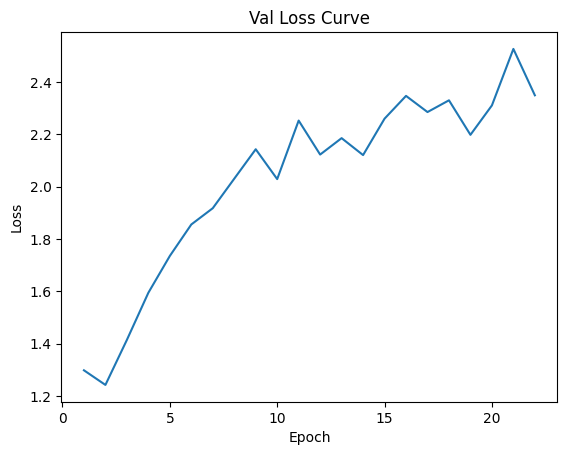

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [26]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.96it/s]


*******Epoch 0: loss - 1.780410028534171


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 1: loss - 1.6490878109578733


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 1.5776094926728144


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.5056318469621517


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.5053345290599046


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.5050804118315378


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.2732467620093145


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 1/300*****
*****Train Loss:  1.503323 Val Loss:  1.012196*****
*****Validation Accuracy: 32.67%*****
*****Total Avg Disparity: 0.0883591846855631*****

Class Team_Sports: Recall Difference = 0.006305832895428187
Class Celebration: Recall Difference = -0.039534883720930225
Class Parade: Recall Difference = -0.02566295979469635
Class Waiter_Or_Waitress: Recall Difference = -0.06287563569116972
Class Individual_Sports: Recall Difference = -0.07901711343328804
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.14789789789789787
Class Business: Recall Difference = -0.12013229488957643
Class Dresses: Recall Difference = -0.2134146341463415
Class Water_Activities: Recall Difference = -0.01145945945945942
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = -0.014683544303797466
Class Cheering: Recall Difference = 0.026866283839212468
Class Performance_And_Entertainment: Recall D

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.2227667248175468


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 2/300*****
*****Train Loss:  1.454521 Val Loss:  0.946112*****
*****Validation Accuracy: 34.43%*****
*****Total Avg Disparity: 0.1302179816005874*****

Class Team_Sports: Recall Difference = 0.11428738249547493
Class Celebration: Recall Difference = -0.1534883720930232
Class Parade: Recall Difference = -0.13487311092101517
Class Waiter_Or_Waitress: Recall Difference = 0.12066574202496536
Class Individual_Sports: Recall Difference = -0.20206724216265332
Class Surgeons: Recall Difference = 0.048780487804878044
Class Spa: Recall Difference = -0.13999999999999999
Class Law_Enforcement: Recall Difference = 0.14489489489489488
Class Business: Recall Difference = -0.206764109676731
Class Dresses: Recall Difference = -0.25338753387533874
Class Water_Activities: Recall Difference = 0.09783783783783762
Class Picnic: Recall Difference = 0.2545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010869565217391304
Class Performance_And_Entertainment:

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.19682844479878744


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 3/300*****
*****Train Loss:  1.406653 Val Loss:  0.890036*****
*****Validation Accuracy: 35.61%*****
*****Total Avg Disparity: 0.13351060334682566*****

Class Team_Sports: Recall Difference = 0.07920826764757405
Class Celebration: Recall Difference = -0.08604651162790694
Class Parade: Recall Difference = -0.011291702309666252
Class Waiter_Or_Waitress: Recall Difference = 0.053629218677762325
Class Individual_Sports: Recall Difference = -0.1345979100408906
Class Surgeons: Recall Difference = -0.030303030303030297
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.19694694694694698
Class Business: Recall Difference = -0.05035740958071055
Class Dresses: Recall Difference = -0.1619241192411925
Class Water_Activities: Recall Difference = 0.0784864864864866
Class Picnic: Recall Difference = 0.6545454545454545
Class Rescue: Recall Difference = 0.005316455696202531
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainme

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.80it/s]


Average Adversary epoch loss: 0.19551452608020217


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 4/300*****
*****Train Loss:  1.360269 Val Loss:  0.907971*****
*****Validation Accuracy: 35.56%*****
*****Total Avg Disparity: 0.14361997183580794*****

Class Team_Sports: Recall Difference = 0.12595317335201728
Class Celebration: Recall Difference = -0.09069767441860468
Class Parade: Recall Difference = 0.05491873396065011
Class Waiter_Or_Waitress: Recall Difference = 0.0023116042533518066
Class Individual_Sports: Recall Difference = -0.11127517794941699
Class Surgeons: Recall Difference = -0.005912786400591275
Class Spa: Recall Difference = -0.34
Class Law_Enforcement: Recall Difference = 0.21921921921921939
Class Business: Recall Difference = -0.1968419929584978
Class Dresses: Recall Difference = -0.4302168021680216
Class Water_Activities: Recall Difference = -0.019999999999999907
Class Picnic: Recall Difference = 0.5454545454545454
Class Rescue: Recall Difference = -0.016708860759493682
Class Cheering: Recall Difference = -0.016611977030352748
Class Performance_And_Enter

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.79it/s]


Average Adversary epoch loss: 0.1857568979907183


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 5/300*****
*****Train Loss:  1.312314 Val Loss:  0.939853*****
*****Validation Accuracy: 34.78%*****
*****Total Avg Disparity: 0.1347517796541959*****

Class Team_Sports: Recall Difference = 0.09188999824837962
Class Celebration: Recall Difference = -0.09767441860465109
Class Parade: Recall Difference = 0.01568291987453657
Class Waiter_Or_Waitress: Recall Difference = 0.13730929264909847
Class Individual_Sports: Recall Difference = -0.06845373315159786
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.14464464464464466
Class Business: Recall Difference = -0.04448949109143284
Class Dresses: Recall Difference = -0.2079945799457995
Class Water_Activities: Recall Difference = -0.044864864864864795
Class Picnic: Recall Difference = 0.6727272727272727
Class Rescue: Recall Difference = -0.0040506329113924044
Class Cheering: Recall Difference = -0.016611977030352748
Class Performance_And_Entertainment: Recall Di

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.72it/s]


Average Adversary epoch loss: 0.18133072384897572


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 6/300*****
*****Train Loss:  1.269155 Val Loss:  0.907096*****
*****Validation Accuracy: 36.62%*****
*****Total Avg Disparity: 0.13404011617835238*****

Class Team_Sports: Recall Difference = 0.11254743971506981
Class Celebration: Recall Difference = 0.03023255813953496
Class Parade: Recall Difference = 0.05839749073282002
Class Waiter_Or_Waitress: Recall Difference = -0.14932963476652794
Class Individual_Sports: Recall Difference = -0.019839466908980807
Class Surgeons: Recall Difference = 0.08573540280857356
Class Spa: Recall Difference = -0.44
Class Law_Enforcement: Recall Difference = 0.12612612612612611
Class Business: Recall Difference = -0.09281980155766562
Class Dresses: Recall Difference = -0.4071815718157182
Class Water_Activities: Recall Difference = 0.06767567567567567
Class Picnic: Recall Difference = 0.38181818181818183
Class Rescue: Recall Difference = 0.0179746835443038
Class Cheering: Recall Difference = -0.011484823625922874
Class Performance_And_Entertainme

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.81it/s]


Average Adversary epoch loss: 0.1782608034066212


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 7/300*****
*****Train Loss:  1.215452 Val Loss:  0.995512*****
*****Validation Accuracy: 37.34%*****
*****Total Avg Disparity: 0.08705866923569143*****

Class Team_Sports: Recall Difference = 0.10491037543060655
Class Celebration: Recall Difference = -0.009302325581395349
Class Parade: Recall Difference = -0.0393498716852011
Class Waiter_Or_Waitress: Recall Difference = 0.07905686546463242
Class Individual_Sports: Recall Difference = -0.08284113281841587
Class Surgeons: Recall Difference = 0.019216555801921664
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.15840840840840836
Class Business: Recall Difference = -0.18990718019844238
Class Dresses: Recall Difference = -0.22154471544715443
Class Water_Activities: Recall Difference = 0.02270270270270275
Class Picnic: Recall Difference = 0.054545454545454536
Class Rescue: Recall Difference = 0.06860759493670886
Class Cheering: Recall Difference = 0.006562756357670223
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.18254165907884823


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 8/300*****
*****Train Loss:  1.153446 Val Loss:  0.937957*****
*****Validation Accuracy: 39.25%*****
*****Total Avg Disparity: 0.09021275353125702*****

Class Team_Sports: Recall Difference = 0.023366614118059292
Class Celebration: Recall Difference = -0.09534883720930232
Class Parade: Recall Difference = -0.01699458226404338
Class Waiter_Or_Waitress: Recall Difference = -0.03744798890429962
Class Individual_Sports: Recall Difference = -0.077502650310465
Class Surgeons: Recall Difference = 0.06208425720620847
Class Spa: Recall Difference = -0.23999999999999996
Class Law_Enforcement: Recall Difference = 0.09984984984985001
Class Business: Recall Difference = -0.16259468686653153
Class Dresses: Recall Difference = -0.3082655826558266
Class Water_Activities: Recall Difference = 0.06410810810810813
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = -0.004050632911392391
Class Cheering: Recall Difference = 0.0008203445447087787
Class Performan

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.17793750427203414


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 9/300*****
*****Train Loss:  1.077809 Val Loss:  0.980003*****
*****Validation Accuracy: 37.11%*****
*****Total Avg Disparity: 0.1022820635757205*****

Class Team_Sports: Recall Difference = 0.08464996788696211
Class Celebration: Recall Difference = -0.05581395348837209
Class Parade: Recall Difference = 0.04613629883090958
Class Waiter_Or_Waitress: Recall Difference = -0.0998613037447989
Class Individual_Sports: Recall Difference = 0.0016659094351052506
Class Surgeons: Recall Difference = -0.01773835920177383
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.07282282282282293
Class Business: Recall Difference = -0.19118745332337567
Class Dresses: Recall Difference = -0.30962059620596216
Class Water_Activities: Recall Difference = 0.12454054054054053
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = -0.038734177215189874
Class Cheering: Recall Difference = 0.01825266611977032
Class Performanc

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.78it/s]


Average Adversary epoch loss: 0.1757958283946838


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 10/300*****
*****Train Loss:  1.021668 Val Loss:  1.006551*****
*****Validation Accuracy: 38.07%*****
*****Total Avg Disparity: 0.13087476892345762*****

Class Team_Sports: Recall Difference = 0.0990249313948735
Class Celebration: Recall Difference = -0.09767441860465118
Class Parade: Recall Difference = -0.021385799828913643
Class Waiter_Or_Waitress: Recall Difference = -0.14331946370781323
Class Individual_Sports: Recall Difference = -0.025745873087990367
Class Surgeons: Recall Difference = 0.05617147080561724
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.01326326326326327
Class Business: Recall Difference = -0.1342152992638429
Class Dresses: Recall Difference = -0.24119241192411922
Class Water_Activities: Recall Difference = 0.08097297297297312
Class Picnic: Recall Difference = 0.4727272727272727
Class Rescue: Recall Difference = 0.07924050632911397
Class Cheering: Recall Difference = -0.03609515996718621
Class Performance_And_Entertain

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.17894693519230243


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 11/300*****
*****Train Loss:  0.956996 Val Loss:  1.125866*****
*****Validation Accuracy: 35.09%*****
*****Total Avg Disparity: 0.10900738448359429*****

Class Team_Sports: Recall Difference = 0.11080749693466446
Class Celebration: Recall Difference = -0.10232558139534881
Class Parade: Recall Difference = 0.0021100655831194637
Class Waiter_Or_Waitress: Recall Difference = -0.2048081368469718
Class Individual_Sports: Recall Difference = 0.012229289716795433
Class Surgeons: Recall Difference = -0.06577974870657796
Class Spa: Recall Difference = -0.07999999999999999
Class Law_Enforcement: Recall Difference = 0.0775775775775775
Class Business: Recall Difference = -0.06572068707991036
Class Dresses: Recall Difference = -0.29268292682926833
Class Water_Activities: Recall Difference = 0.06800000000000006
Class Picnic: Recall Difference = 0.38181818181818183
Class Rescue: Recall Difference = -0.01670886075949367
Class Cheering: Recall Difference = -0.04122231337161608
Class Performa

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.79it/s]


Average Adversary epoch loss: 0.17881121661192106


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 12/300*****
*****Train Loss:  0.899691 Val Loss:  1.094869*****
*****Validation Accuracy: 35.76%*****
*****Total Avg Disparity: 0.12980721137143988*****

Class Team_Sports: Recall Difference = 0.1188883050154726
Class Celebration: Recall Difference = -0.1209302325581395
Class Parade: Recall Difference = 0.05816937553464496
Class Waiter_Or_Waitress: Recall Difference = 0.0277392510402219
Class Individual_Sports: Recall Difference = -0.0685673178858095
Class Surgeons: Recall Difference = 0.03178122690317817
Class Spa: Recall Difference = -0.42
Class Law_Enforcement: Recall Difference = -0.004004004004004025
Class Business: Recall Difference = -0.09228635442227676
Class Dresses: Recall Difference = -0.451219512195122
Class Water_Activities: Recall Difference = 0.0025945945945946014
Class Picnic: Recall Difference = 0.4363636363636363
Class Rescue: Recall Difference = 0.06455696202531648
Class Cheering: Recall Difference = 0.03999179655455292
Class Performance_And_Entertainment:

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.82it/s]


Average Adversary epoch loss: 0.18067637315870802


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 13/300*****
*****Train Loss:  0.809191 Val Loss:  1.142860*****
*****Validation Accuracy: 36.31%*****
*****Total Avg Disparity: 0.10808847187468251*****

Class Team_Sports: Recall Difference = 0.11030536579669525
Class Celebration: Recall Difference = -0.09302325581395349
Class Parade: Recall Difference = 0.05406330196749359
Class Waiter_Or_Waitress: Recall Difference = -0.0073971336107258034
Class Individual_Sports: Recall Difference = -0.08102377707102831
Class Surgeons: Recall Difference = 0.10569105691056913
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.1351351351351351
Class Business: Recall Difference = -0.08951242931825454
Class Dresses: Recall Difference = -0.31571815718157187
Class Water_Activities: Recall Difference = 0.07621621621621621
Class Picnic: Recall Difference = 0.1818181818181818
Class Rescue: Recall Difference = -0.05544303797468353
Class Cheering: Recall Difference = 0.004511894995898269
Class Performance_And_Entertai

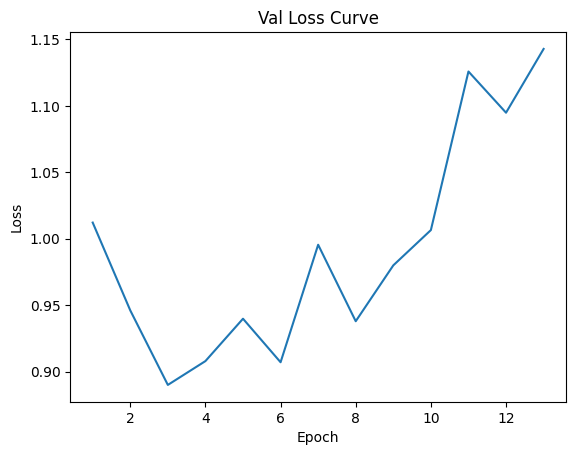

Student weights and architecture saved and exported for lambda: 10


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 0: loss - 1.7663953377876753


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 1: loss - 1.64285847949393


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 1.5697881285055184


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.3774460259779


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.3776234707530634


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.3776160752699699


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.21258509600604023


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 1/300*****
*****Train Loss:  1.510920 Val Loss:  0.947267*****
*****Validation Accuracy: 32.87%*****
*****Total Avg Disparity: 0.10204120776778408*****

Class Team_Sports: Recall Difference = 0.13235242599404445
Class Celebration: Recall Difference = -0.05348837209302325
Class Parade: Recall Difference = 0.01842030225263752
Class Waiter_Or_Waitress: Recall Difference = -0.09015256588072124
Class Individual_Sports: Recall Difference = -0.12880508859609274
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.16241241241241244
Class Business: Recall Difference = -0.04907713645577723
Class Dresses: Recall Difference = -0.08739837398373995
Class Water_Activities: Recall Difference = 0.1046486486486487
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.08220461708833807
Clas

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.19006802693561273


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 2/300*****
*****Train Loss:  1.460311 Val Loss:  0.903973*****
*****Validation Accuracy: 35.35%*****
*****Total Avg Disparity: 0.12418590659316159*****

Class Team_Sports: Recall Difference = 0.09688795469142292
Class Celebration: Recall Difference = -0.009302325581395376
Class Parade: Recall Difference = 0.026518391787852758
Class Waiter_Or_Waitress: Recall Difference = 0.009246417013407338
Class Individual_Sports: Recall Difference = 0.0007193699833408784
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.42
Class Law_Enforcement: Recall Difference = 0.19694694694694698
Class Business: Recall Difference = -0.09153952843273228
Class Dresses: Recall Difference = -0.16937669376693765
Class Water_Activities: Recall Difference = 0.09827027027027019
Class Picnic: Recall Difference = -0.2363636363636364
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0725785842064911
Cl

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.18034420498175385


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 3/300*****
*****Train Loss:  1.408399 Val Loss:  0.892483*****
*****Validation Accuracy: 34.63%*****
*****Total Avg Disparity: 0.11182143640352046*****

Class Team_Sports: Recall Difference = 0.2248379751269925
Class Celebration: Recall Difference = 0.07674418604651168
Class Parade: Recall Difference = 0.03718277730253777
Class Waiter_Or_Waitress: Recall Difference = -0.12112806287563577
Class Individual_Sports: Recall Difference = -0.11252461002574582
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.09999999999999999
Class Law_Enforcement: Recall Difference = 0.07682682682682687
Class Business: Recall Difference = -0.10071481916142111
Class Dresses: Recall Difference = -0.31300813008130085
Class Water_Activities: Recall Difference = 0.07956756756756755
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.03773584905660377
Class Performance_And_Entertainment: Recall Differe

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.170825594737206


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 4/300*****
*****Train Loss:  1.369382 Val Loss:  0.907659*****
*****Validation Accuracy: 35.27%*****
*****Total Avg Disparity: 0.1198929374109651*****

Class Team_Sports: Recall Difference = 0.1883575640801074
Class Celebration: Recall Difference = 0.086046511627907
Class Parade: Recall Difference = -0.012375249500998109
Class Waiter_Or_Waitress: Recall Difference = 0.018955154877485114
Class Individual_Sports: Recall Difference = 0.021656822656368313
Class Surgeons: Recall Difference = 0.04878048780487805
Class Spa: Recall Difference = -0.5799999999999998
Class Law_Enforcement: Recall Difference = 0.004254254254254297
Class Business: Recall Difference = -0.10327536541128775
Class Dresses: Recall Difference = -0.22154471544715443
Class Water_Activities: Recall Difference = 0.08670270270270275
Class Picnic: Recall Difference = 0.21818181818181814
Class Rescue: Recall Difference = 0.005316455696202531
Class Cheering: Recall Difference = -0.0014356029532403593
Class Performance

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.17051753102813239


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 5/300*****
*****Train Loss:  1.318913 Val Loss:  0.899404*****
*****Validation Accuracy: 37.06%*****
*****Total Avg Disparity: 0.10330864150653797*****

Class Team_Sports: Recall Difference = 0.1318970047293747
Class Celebration: Recall Difference = 0.0023255813953488857
Class Parade: Recall Difference = 0.09461077844311377
Class Waiter_Or_Waitress: Recall Difference = 0.04715672676837723
Class Individual_Sports: Recall Difference = 0.0007193699833408784
Class Surgeons: Recall Difference = 0.04286770140428678
Class Spa: Recall Difference = -0.26
Class Law_Enforcement: Recall Difference = 0.1666666666666668
Class Business: Recall Difference = -0.10967673103595432
Class Dresses: Recall Difference = -0.40582655826558256
Class Water_Activities: Recall Difference = 0.028216216216216283
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.023291139240506326
Class Cheering: Recall Difference = 0.009433962264150941
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.73it/s]


Average Adversary epoch loss: 0.1713836744059751


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 6/300*****
*****Train Loss:  1.264609 Val Loss:  0.887219*****
*****Validation Accuracy: 38.35%*****
*****Total Avg Disparity: 0.11294069881603916*****

Class Team_Sports: Recall Difference = 0.19211770888071467
Class Celebration: Recall Difference = 0.04186046511627908
Class Parade: Recall Difference = 0.030909609352723133
Class Waiter_Or_Waitress: Recall Difference = -0.07720758206195111
Class Individual_Sports: Recall Difference = -0.12384522186884744
Class Surgeons: Recall Difference = 0.031042128603104208
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.2354854854854854
Class Business: Recall Difference = -0.18147871545929795
Class Dresses: Recall Difference = -0.4315718157181571
Class Water_Activities: Recall Difference = 0.02086486486486494
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.01797468354430379
Class Cheering: Recall Difference = 0.01968826907301066
Class Performance

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.1712071381877234


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 7/300*****
*****Train Loss:  1.208641 Val Loss:  0.917177*****
*****Validation Accuracy: 37.92%*****
*****Total Avg Disparity: 0.10761857571729316*****

Class Team_Sports: Recall Difference = 0.19177906229929348
Class Celebration: Recall Difference = -0.01860465116279067
Class Parade: Recall Difference = 0.03473053892215566
Class Waiter_Or_Waitress: Recall Difference = -0.14239482200647252
Class Individual_Sports: Recall Difference = -0.10586097228532482
Class Surgeons: Recall Difference = 0.03695491500369549
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.15640640640640652
Class Business: Recall Difference = -0.11351755041075431
Class Dresses: Recall Difference = -0.23373983739837395
Class Water_Activities: Recall Difference = -0.0219459459459459
Class Picnic: Recall Difference = 0.09090909090909088
Class Rescue: Recall Difference = 0.006582278481012685
Class Cheering: Recall Difference = -0.007178014766201807
Class Performan

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.1717870408370171


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 8/300*****
*****Train Loss:  1.164451 Val Loss:  0.944107*****
*****Validation Accuracy: 38.10%*****
*****Total Avg Disparity: 0.10992171976076137*****

Class Team_Sports: Recall Difference = 0.16159280667951187
Class Celebration: Recall Difference = 0.025581395348837188
Class Parade: Recall Difference = 0.009980039920159667
Class Waiter_Or_Waitress: Recall Difference = 0.07258437355524727
Class Individual_Sports: Recall Difference = -0.05171891564440401
Class Surgeons: Recall Difference = -0.06577974870657796
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.05880880880880879
Class Business: Recall Difference = -0.17230342473060917
Class Dresses: Recall Difference = -0.35230352303523044
Class Water_Activities: Recall Difference = 0.004540540540540483
Class Picnic: Recall Difference = 0.09090909090909083
Class Rescue: Recall Difference = 0.0379746835443038
Class Cheering: Recall Difference = -0.10213289581624282
Class Performance_And_Entertain

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.16924204061060777


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 9/300*****
*****Train Loss:  1.105761 Val Loss:  1.061409*****
*****Validation Accuracy: 35.30%*****
*****Total Avg Disparity: 0.09660926453037266*****

Class Team_Sports: Recall Difference = 0.19076312255503003
Class Celebration: Recall Difference = -0.07441860465116279
Class Parade: Recall Difference = 0.02897063016823498
Class Waiter_Or_Waitress: Recall Difference = -0.10078594544613961
Class Individual_Sports: Recall Difference = -0.046569741026806055
Class Surgeons: Recall Difference = -0.005173688100517354
Class Spa: Recall Difference = -0.39999999999999997
Class Law_Enforcement: Recall Difference = 0.11636636636636638
Class Business: Recall Difference = -0.02837938760268858
Class Dresses: Recall Difference = -0.22425474254742545
Class Water_Activities: Recall Difference = 0.03762162162162164
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = -0.016708860759493654
Class Cheering: Recall Difference = -0.021739130434782605
Class Perf

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.1697502736416128


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 10/300*****
*****Train Loss:  1.039828 Val Loss:  1.016501*****
*****Validation Accuracy: 37.26%*****
*****Total Avg Disparity: 0.12414112412100758*****

Class Team_Sports: Recall Difference = 0.1543527763180943
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = 0.013515825491873357
Class Waiter_Or_Waitress: Recall Difference = -0.10448451225150257
Class Individual_Sports: Recall Difference = -0.06693927002877487
Class Surgeons: Recall Difference = 0.03695491500369548
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.09434434434434441
Class Business: Recall Difference = -0.09207297556812122
Class Dresses: Recall Difference = -0.44376693766937664
Class Water_Activities: Recall Difference = 0.15621621621621629
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = -0.0020253164556962022
Class Cheering: Recall Difference = -0.05639868744872849
Class Performance_And_Ente

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.17153681281172198


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 11/300*****
*****Train Loss:  0.982070 Val Loss:  1.029907*****
*****Validation Accuracy: 38.85%*****
*****Total Avg Disparity: 0.09525858813789145*****

Class Team_Sports: Recall Difference = 0.1491329479768787
Class Celebration: Recall Difference = -0.011627906976744151
Class Parade: Recall Difference = -0.00011405759908755808
Class Waiter_Or_Waitress: Recall Difference = 0.01987979657882566
Class Individual_Sports: Recall Difference = -0.008897470846584932
Class Surgeons: Recall Difference = 0.007390983000739176
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.09459459459459463
Class Business: Recall Difference = -0.1147978235356876
Class Dresses: Recall Difference = -0.3204607046070461
Class Water_Activities: Recall Difference = 0.05362162162162171
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = -0.0020253164556962022
Class Cheering: Recall Difference = 0.039991796554552914
Class Perf

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.16959136039202596


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 12/300*****
*****Train Loss:  0.910966 Val Loss:  1.036540*****
*****Validation Accuracy: 36.74%*****
*****Total Avg Disparity: 0.12829256677094025*****

Class Team_Sports: Recall Difference = 0.15507677935423603
Class Celebration: Recall Difference = 0.002325581395348858
Class Parade: Recall Difference = 0.0050755631593954464
Class Waiter_Or_Waitress: Recall Difference = 0.038372630605640445
Class Individual_Sports: Recall Difference = -0.007458730879903064
Class Surgeons: Recall Difference = 0.018477457501847747
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.20220220220220225
Class Business: Recall Difference = -0.1528859490024539
Class Dresses: Recall Difference = -0.451219512195122
Class Water_Activities: Recall Difference = 0.10021621621621618
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = -0.006075949367088607
Class Cheering: Recall Difference = -0.06070549630844954
Class Performance_And_Enter

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.73it/s]


Average Adversary epoch loss: 0.16889076118851887


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 13/300*****
*****Train Loss:  0.849767 Val Loss:  1.070863*****
*****Validation Accuracy: 37.11%*****
*****Total Avg Disparity: 0.13407197778540603*****

Class Team_Sports: Recall Difference = 0.1742745372803176
Class Celebration: Recall Difference = -0.03255813953488371
Class Parade: Recall Difference = -0.02731679498146561
Class Waiter_Or_Waitress: Recall Difference = -0.0568654646324549
Class Individual_Sports: Recall Difference = -0.11252461002574593
Class Surgeons: Recall Difference = -0.053215077605321515
Class Spa: Recall Difference = -0.29999999999999993
Class Law_Enforcement: Recall Difference = 0.10435435435435436
Class Business: Recall Difference = -0.16515523311639818
Class Dresses: Recall Difference = -0.2716802168021681
Class Water_Activities: Recall Difference = 0.14962162162162168
Class Picnic: Recall Difference = 0.6
Class Rescue: Recall Difference = 0.0012658227848101195
Class Cheering: Recall Difference = -0.010049220672682518
Class Performance_And_Enterta

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.16887773614790705


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 14/300*****
*****Train Loss:  0.791720 Val Loss:  1.155837*****
*****Validation Accuracy: 35.38%*****
*****Total Avg Disparity: 0.09983654490160171*****

Class Team_Sports: Recall Difference = 0.1151281602148655
Class Celebration: Recall Difference = 0.009302325581395349
Class Parade: Recall Difference = -0.016424294268605644
Class Waiter_Or_Waitress: Recall Difference = 0.002311604253351862
Class Individual_Sports: Recall Difference = -0.09064061790095412
Class Surgeons: Recall Difference = 0.0687361419068736
Class Spa: Recall Difference = -0.34
Class Law_Enforcement: Recall Difference = 0.14139139139139145
Class Business: Recall Difference = -0.041182118852021776
Class Dresses: Recall Difference = -0.45731707317073167
Class Water_Activities: Recall Difference = 0.016648648648648623
Class Picnic: Recall Difference = 0.018181818181818132
Class Rescue: Recall Difference = -0.03139240506329112
Class Cheering: Recall Difference = -0.06296144380639869
Class Performance_And_Enter

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.17033165550710241


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 15/300*****
*****Train Loss:  0.723668 Val Loss:  1.176857*****
*****Validation Accuracy: 34.89%*****
*****Total Avg Disparity: 0.14520321967658995*****

Class Team_Sports: Recall Difference = 0.19913586734395977
Class Celebration: Recall Difference = 0.04418604651162794
Class Parade: Recall Difference = -0.01368691189050475
Class Waiter_Or_Waitress: Recall Difference = -0.16181229773462785
Class Individual_Sports: Recall Difference = 0.03441617446615175
Class Surgeons: Recall Difference = -0.0953436807095343
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.16191191191191195
Class Business: Recall Difference = -0.04886375760162176
Class Dresses: Recall Difference = -0.5670731707317074
Class Water_Activities: Recall Difference = 0.10962162162162165
Class Picnic: Recall Difference = 0.09090909090909088
Class Rescue: Recall Difference = 0.01594936708860758
Class Cheering: Recall Difference = -0.007793273174733384
Class Performance_And_Entertainm

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.17205653831730655


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 16/300*****
*****Train Loss:  0.658978 Val Loss:  1.243331*****
*****Validation Accuracy: 36.48%*****
*****Total Avg Disparity: 0.09676386080693773*****

Class Team_Sports: Recall Difference = 0.1074910959304024
Class Celebration: Recall Difference = -0.03720930232558142
Class Parade: Recall Difference = 0.024123182207014537
Class Waiter_Or_Waitress: Recall Difference = 0.01109570041608876
Class Individual_Sports: Recall Difference = -0.023549901559897002
Class Surgeons: Recall Difference = -0.053215077605321515
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.04054054054054046
Class Business: Recall Difference = -0.08513816280806571
Class Dresses: Recall Difference = -0.3719512195121951
Class Water_Activities: Recall Difference = 0.029081081081081095
Class Picnic: Recall Difference = 0.05454545454545451
Class Rescue: Recall Difference = 0.08658227848101263
Class Cheering: Recall Difference = -0.08100902378999178
Class Performance_And_Enterta

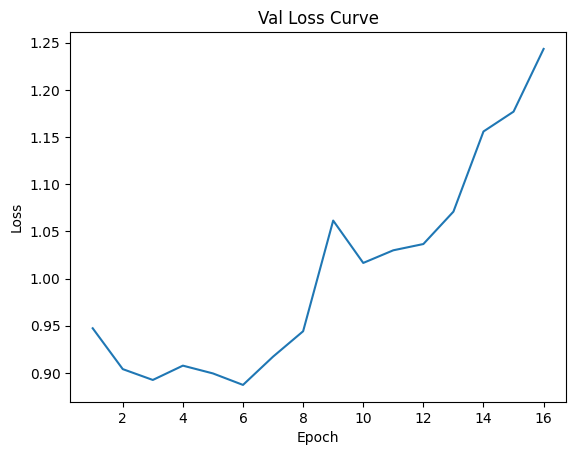

Student weights and architecture saved and exported for lambda: 5


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 0: loss - 1.7725616016505676


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.96it/s]


*******Epoch 1: loss - 1.657535082028236


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 1.5812475269223436


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.58it/s]


Average Pretrain Adversary epoch loss:  0.36820324997843046


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.58it/s]


Average Pretrain Adversary epoch loss:  0.36776959822501665


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.58it/s]


Average Pretrain Adversary epoch loss:  0.3680590757249314


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.81it/s]


Average Adversary epoch loss: 0.2651229476855125


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 1/300*****
*****Train Loss:  1.531693 Val Loss:  1.013829*****
*****Validation Accuracy: 28.92%*****
*****Total Avg Disparity: 0.0710672780812065*****

Class Team_Sports: Recall Difference = 0.08858527471244232
Class Celebration: Recall Difference = -0.08372093023255814
Class Parade: Recall Difference = -0.018135158254918626
Class Waiter_Or_Waitress: Recall Difference = -0.04068423485899214
Class Individual_Sports: Recall Difference = -0.013440860215053752
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.06
Class Law_Enforcement: Recall Difference = 0.12287287287287285
Class Business: Recall Difference = -0.19577509868772008
Class Dresses: Recall Difference = -0.18631436314363148
Class Water_Activities: Recall Difference = 0.08540540540540542
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.015176374077112385
Class Performance_And_Entertainment: Recall Difference = -0.0

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.82it/s]


Average Adversary epoch loss: 0.19022576961620355


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 2/300*****
*****Train Loss:  1.479663 Val Loss:  1.042927*****
*****Validation Accuracy: 32.73%*****
*****Total Avg Disparity: 0.09660366573152826*****

Class Team_Sports: Recall Difference = 0.14649384013545869
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = 0.007470772740233778
Class Waiter_Or_Waitress: Recall Difference = -0.0596393897364772
Class Individual_Sports: Recall Difference = 0.058874753899742505
Class Surgeons: Recall Difference = 0.03104212860310422
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.24549549549549554
Class Business: Recall Difference = -0.05654539635122163
Class Dresses: Recall Difference = -0.3231707317073171
Class Water_Activities: Recall Difference = 0.05718918918918914
Class Picnic: Recall Difference = 0.29090909090909084
Class Rescue: Recall Difference = -0.02
Class Cheering: Recall Difference = 0.009433962264150943
Class Performance_And_Entertainment: Recall Di

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.79it/s]


Average Adversary epoch loss: 0.17968932943947521


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 3/300*****
*****Train Loss:  1.431152 Val Loss:  0.946503*****
*****Validation Accuracy: 34.98%*****
*****Total Avg Disparity: 0.06871982920121597*****

Class Team_Sports: Recall Difference = 0.05563145909966716
Class Celebration: Recall Difference = -0.037209302325581395
Class Parade: Recall Difference = 0.008041060735671512
Class Waiter_Or_Waitress: Recall Difference = -0.08506703652334724
Class Individual_Sports: Recall Difference = 0.004051188853551435
Class Surgeons: Recall Difference = 0.0014781966001478353
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.1441441441441442
Class Business: Recall Difference = -0.058572495465699426
Class Dresses: Recall Difference = 0.1897018970189701
Class Water_Activities: Recall Difference = 0.10735135135135129
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.04491386382280558
Class Performance_And_Entertainment: Recall D

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.79it/s]


Average Adversary epoch loss: 0.17500724574482


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s]


*****Epoch 4/300*****
*****Train Loss:  1.383244 Val Loss:  0.904449*****
*****Validation Accuracy: 36.25%*****
*****Total Avg Disparity: 0.08899201443394761*****

Class Team_Sports: Recall Difference = 0.06988964792433006
Class Celebration: Recall Difference = -0.13488372093023251
Class Parade: Recall Difference = 0.047790134017678954
Class Waiter_Or_Waitress: Recall Difference = -0.09754969949144698
Class Individual_Sports: Recall Difference = -0.03971679539603218
Class Surgeons: Recall Difference = 0.019216555801921692
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.049049049049049054
Class Business: Recall Difference = -0.17945161634482026
Class Dresses: Recall Difference = -0.0873983739837399
Class Water_Activities: Recall Difference = 0.09059459459459462
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = 0.010632911392405069
Class Cheering: Recall Difference = 0.003691550451189511
Class Performance_And_Enterta

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.82it/s]


Average Adversary epoch loss: 0.17270275214572012


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 5/300*****
*****Train Loss:  1.338370 Val Loss:  0.919632*****
*****Validation Accuracy: 38.18%*****
*****Total Avg Disparity: 0.1127435985753544*****

Class Team_Sports: Recall Difference = 0.0438488935598762
Class Celebration: Recall Difference = -0.13488372093023254
Class Parade: Recall Difference = -0.0003992015968063978
Class Waiter_Or_Waitress: Recall Difference = -0.0568654646324549
Class Individual_Sports: Recall Difference = -0.11089656216871124
Class Surgeons: Recall Difference = 0.0007390983000739038
Class Spa: Recall Difference = -0.2
Class Law_Enforcement: Recall Difference = 0.1331331331331333
Class Business: Recall Difference = -0.1206657420249653
Class Dresses: Recall Difference = -0.3292682926829268
Class Water_Activities: Recall Difference = 0.04648648648648657
Class Picnic: Recall Difference = 0.4363636363636363
Class Rescue: Recall Difference = 0.050632911392405056
Class Cheering: Recall Difference = 0.007998359310910582
Class Performance_And_Entertainmen

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.81it/s]


Average Adversary epoch loss: 0.17603207034645257


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 6/300*****
*****Train Loss:  1.276162 Val Loss:  0.981345*****
*****Validation Accuracy: 37.46%*****
*****Total Avg Disparity: 0.09642671467027533*****

Class Team_Sports: Recall Difference = 0.10833187364979269
Class Celebration: Recall Difference = 0.03953488372093025
Class Parade: Recall Difference = -0.04944396920444827
Class Waiter_Or_Waitress: Recall Difference = -0.02681460933888119
Class Individual_Sports: Recall Difference = -0.037255792821444755
Class Surgeons: Recall Difference = -0.08425720620842574
Class Spa: Recall Difference = -0.06
Class Law_Enforcement: Recall Difference = 0.1328828828828829
Class Business: Recall Difference = -0.09356662754721007
Class Dresses: Recall Difference = -0.3279132791327914
Class Water_Activities: Recall Difference = 0.13827027027027028
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = -0.007341772151898731
Class Cheering: Recall Difference = -0.0028712059064807186
Class Performance_And_Enter

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.78it/s]


Average Adversary epoch loss: 0.1725202041827602


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 7/300*****
*****Train Loss:  1.226303 Val Loss:  0.941938*****
*****Validation Accuracy: 34.49%*****
*****Total Avg Disparity: 0.12145358734659724*****

Class Team_Sports: Recall Difference = 0.1160857126175045
Class Celebration: Recall Difference = -0.048837209302325546
Class Parade: Recall Difference = -0.003877958368976392
Class Waiter_Or_Waitress: Recall Difference = -0.12390198797965785
Class Individual_Sports: Recall Difference = -0.088255338482508
Class Surgeons: Recall Difference = 0.019216555801921664
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.1166166166166166
Class Business: Recall Difference = -0.1508588498879761
Class Dresses: Recall Difference = -0.4390243902439025
Class Water_Activities: Recall Difference = 0.1275675675675677
Class Picnic: Recall Difference = 0.2909090909090909
Class Rescue: Recall Difference = -0.07999999999999999
Class Cheering: Recall Difference = 0.007998359310910582
Class Performance_And_Entertainment

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.81it/s]


Average Adversary epoch loss: 0.16927962060327884


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 8/300*****
*****Train Loss:  1.164875 Val Loss:  0.920759*****
*****Validation Accuracy: 39.05%*****
*****Total Avg Disparity: 0.1256700405848261*****

Class Team_Sports: Recall Difference = 0.14413499153383547
Class Celebration: Recall Difference = 5.551115123125783e-17
Class Parade: Recall Difference = 0.0744796122041631
Class Waiter_Or_Waitress: Recall Difference = -0.10540915395284334
Class Individual_Sports: Recall Difference = -0.010033318188702123
Class Surgeons: Recall Difference = 0.0376940133037694
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.1208708708708709
Class Business: Recall Difference = -0.04374266510188843
Class Dresses: Recall Difference = -0.5365853658536587
Class Water_Activities: Recall Difference = 0.03081081081081094
Class Picnic: Recall Difference = 0.23636363636363633
Class Rescue: Recall Difference = 0.0159493670886076
Class Cheering: Recall Difference = -0.06009023789991796
Class Performance_And_Entertainment: 

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.80it/s]


Average Adversary epoch loss: 0.16888322271866563


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 9/300*****
*****Train Loss:  1.099573 Val Loss:  0.984017*****
*****Validation Accuracy: 38.12%*****
*****Total Avg Disparity: 0.11322301966515161*****

Class Team_Sports: Recall Difference = 0.08173060080574535
Class Celebration: Recall Difference = -0.044186046511627886
Class Parade: Recall Difference = 0.06763615625891067
Class Waiter_Or_Waitress: Recall Difference = -0.18122977346278318
Class Individual_Sports: Recall Difference = 0.0711419051946085
Class Surgeons: Recall Difference = -0.06577974870657796
Class Spa: Recall Difference = -0.23999999999999996
Class Law_Enforcement: Recall Difference = 0.1228728728728729
Class Business: Recall Difference = -0.037127920623066246
Class Dresses: Recall Difference = -0.3292682926829268
Class Water_Activities: Recall Difference = 0.010594594594594664
Class Picnic: Recall Difference = 0.32727272727272727
Class Rescue: Recall Difference = 0.06860759493670886
Class Cheering: Recall Difference = -0.020918785890073816
Class Performanc

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.79it/s]


Average Adversary epoch loss: 0.1719903660317262


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 10/300*****
*****Train Loss:  1.040923 Val Loss:  0.971770*****
*****Validation Accuracy: 39.45%*****
*****Total Avg Disparity: 0.12798413082015392*****

Class Team_Sports: Recall Difference = 0.11837449640917852
Class Celebration: Recall Difference = -0.09534883720930229
Class Parade: Recall Difference = 0.029826062161391442
Class Waiter_Or_Waitress: Recall Difference = -0.17152103559870552
Class Individual_Sports: Recall Difference = -0.08825533848250794
Class Surgeons: Recall Difference = 0.09238728750923877
Class Spa: Recall Difference = -0.22
Class Law_Enforcement: Recall Difference = 0.15665665665665673
Class Business: Recall Difference = -0.10124826629680994
Class Dresses: Recall Difference = -0.4573170731707317
Class Water_Activities: Recall Difference = 0.13697297297297295
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = -0.04075949367088608
Class Cheering: Recall Difference = -0.04409351927809681
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.81it/s]


Average Adversary epoch loss: 0.16870191490944522


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 11/300*****
*****Train Loss:  0.977657 Val Loss:  1.005382*****
*****Validation Accuracy: 37.78%*****
*****Total Avg Disparity: 0.12672421012472715*****

Class Team_Sports: Recall Difference = 0.11899340223039645
Class Celebration: Recall Difference = 0.011627906976744207
Class Parade: Recall Difference = -0.052637581978899395
Class Waiter_Or_Waitress: Recall Difference = -0.16458622283864988
Class Individual_Sports: Recall Difference = -0.06674996213842199
Class Surgeons: Recall Difference = 0.0753880266075388
Class Spa: Recall Difference = -0.26
Class Law_Enforcement: Recall Difference = 0.24074074074074087
Class Business: Recall Difference = -0.010028806145311042
Class Dresses: Recall Difference = -0.31097560975609756
Class Water_Activities: Recall Difference = 0.12064864864864872
Class Picnic: Recall Difference = 0.4181818181818181
Class Rescue: Recall Difference = -0.05139240506329114
Class Cheering: Recall Difference = -0.0404019688269073
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.80it/s]


Average Adversary epoch loss: 0.17000837196354512


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 12/300*****
*****Train Loss:  0.910145 Val Loss:  1.068390*****
*****Validation Accuracy: 36.62%*****
*****Total Avg Disparity: 0.11665739406407602*****

Class Team_Sports: Recall Difference = 0.15794943656215338
Class Celebration: Recall Difference = -0.004651162790697688
Class Parade: Recall Difference = 0.04208725406330199
Class Waiter_Or_Waitress: Recall Difference = -0.20943134535367547
Class Individual_Sports: Recall Difference = -0.0018552173254581805
Class Surgeons: Recall Difference = 0.03104212860310422
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.10260260260260262
Class Business: Recall Difference = -0.11789181692094314
Class Dresses: Recall Difference = -0.4681571815718157
Class Water_Activities: Recall Difference = 0.13200000000000006
Class Picnic: Recall Difference = -0.09090909090909097
Class Rescue: Recall Difference = -0.011392405063291158
Class Cheering: Recall Difference = -0.07526661197703037
Class Perfo

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.1683774928987762


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 13/300*****
*****Train Loss:  0.827165 Val Loss:  1.107642*****
*****Validation Accuracy: 37.43%*****
*****Total Avg Disparity: 0.10931213460333572*****

Class Team_Sports: Recall Difference = 0.12651369183161087
Class Celebration: Recall Difference = -0.07674418604651168
Class Parade: Recall Difference = -0.015397775876817787
Class Waiter_Or_Waitress: Recall Difference = -0.1793804900601017
Class Individual_Sports: Recall Difference = -0.02411782523095557
Class Surgeons: Recall Difference = 0.09238728750923875
Class Spa: Recall Difference = -0.19999999999999998
Class Law_Enforcement: Recall Difference = 0.09209209209209207
Class Business: Recall Difference = -0.039901845727088436
Class Dresses: Recall Difference = -0.4329268292682926
Class Water_Activities: Recall Difference = 0.10713513513513512
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = -0.04202531645569621
Class Cheering: Recall Difference = 0.005947497949138653
Class Perform

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.1684543672995067


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 14/300*****
*****Train Loss:  0.762683 Val Loss:  1.120133*****
*****Validation Accuracy: 39.42%*****
*****Total Avg Disparity: 0.13460976004888198*****

Class Team_Sports: Recall Difference = 0.0949144625445203
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.04944396920444827
Class Waiter_Or_Waitress: Recall Difference = -0.22884882108183074
Class Individual_Sports: Recall Difference = -0.023549901559897057
Class Surgeons: Recall Difference = 0.08647450110864752
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.144894894894895
Class Business: Recall Difference = -0.08311106369358795
Class Dresses: Recall Difference = -0.4315718157181572
Class Water_Activities: Recall Difference = 0.12313513513513513
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = -0.10405063291139241
Class Cheering: Recall Difference = -0.002050861361771933
Class Performance_And_Entertainment: Recall Diffe

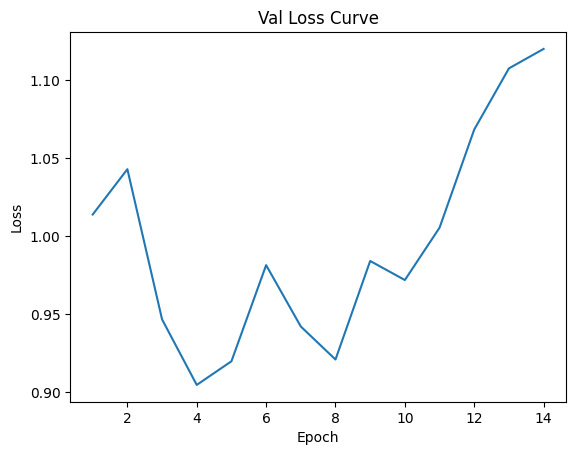

Student weights and architecture saved and exported for lambda: 3


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 0: loss - 1.7786473999788732


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 1: loss - 1.6510460987503146


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 1.5753579485563585


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.3641383683791867


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.36479562796928267


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.3647219995841568


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.3287082152602113


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 1/300*****
*****Train Loss:  1.523676 Val Loss:  0.956333*****
*****Validation Accuracy: 31.37%*****
*****Total Avg Disparity: 0.07858374546906385*****

Class Team_Sports: Recall Difference = 0.08062124131488291
Class Celebration: Recall Difference = -0.08139534883720931
Class Parade: Recall Difference = -0.042600513259195893
Class Waiter_Or_Waitress: Recall Difference = 0.0859916782246879
Class Individual_Sports: Recall Difference = -0.10491443283356056
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.12
Class Law_Enforcement: Recall Difference = 0.05180180180180183
Class Business: Recall Difference = -0.09175290728688787
Class Dresses: Recall Difference = -0.14092140921409224
Class Water_Activities: Recall Difference = 0.05859459459459465
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = -0.007341772151898735
Class Cheering: Recall Difference = -0.010869565217391302
Class Performance_And_Entertainment: Recall 

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.23554526044078816


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 2/300*****
*****Train Loss:  1.469086 Val Loss:  0.979970*****
*****Validation Accuracy: 32.50%*****
*****Total Avg Disparity: 0.09673634495445498*****

Class Team_Sports: Recall Difference = 0.13179190751445097
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = -0.05514684915882517
Class Waiter_Or_Waitress: Recall Difference = -0.0443828016643551
Class Individual_Sports: Recall Difference = -0.17533696804482807
Class Surgeons: Recall Difference = 0.042867701404286786
Class Spa: Recall Difference = -0.30000000000000004
Class Law_Enforcement: Recall Difference = 0.10035035035035034
Class Business: Recall Difference = -0.08076389629787689
Class Dresses: Recall Difference = -0.3109756097560976
Class Water_Activities: Recall Difference = 0.03210810810810821
Class Picnic: Recall Difference = 0.10909090909090907
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010869565217391302
Class Performance_And_Entertainm

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.72it/s]


Average Adversary epoch loss: 0.193455720619287


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 3/300*****
*****Train Loss:  1.420647 Val Loss:  0.947239*****
*****Validation Accuracy: 33.97%*****
*****Total Avg Disparity: 0.13780828243399518*****

Class Team_Sports: Recall Difference = 0.09856951013020382
Class Celebration: Recall Difference = -0.01395348837209301
Class Parade: Recall Difference = -0.05725691474194472
Class Waiter_Or_Waitress: Recall Difference = -0.012482662968099856
Class Individual_Sports: Recall Difference = -0.050090867787369375
Class Surgeons: Recall Difference = -0.04212860310421285
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.08683683683683685
Class Business: Recall Difference = -0.19246772644830895
Class Dresses: Recall Difference = -0.28387533875338755
Class Water_Activities: Recall Difference = -0.07848648648648648
Class Picnic: Recall Difference = 0.36363636363636365
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.005127153404429853
Class Performance_And_Entertainment: Recall 

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.79it/s]


Average Adversary epoch loss: 0.19185503135308807


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 4/300*****
*****Train Loss:  1.377916 Val Loss:  0.894633*****
*****Validation Accuracy: 36.94%*****
*****Total Avg Disparity: 0.10507543841702441*****

Class Team_Sports: Recall Difference = 0.10726922403222983
Class Celebration: Recall Difference = -0.08372093023255811
Class Parade: Recall Difference = 0.03279155973766751
Class Waiter_Or_Waitress: Recall Difference = 0.026814609338881135
Class Individual_Sports: Recall Difference = 0.016810540663334872
Class Surgeons: Recall Difference = -0.005912786400591279
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.12937937937937943
Class Business: Recall Difference = -0.18329243571962012
Class Dresses: Recall Difference = -0.2974254742547426
Class Water_Activities: Recall Difference = 0.0729729729729729
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = 0.012658227848101266
Class Cheering: Recall Difference = 0.017432321575061527
Class Performance_And_Entertain

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.76it/s]


Average Adversary epoch loss: 0.1791786949759648


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 5/300*****
*****Train Loss:  1.334145 Val Loss:  0.909874*****
*****Validation Accuracy: 37.86%*****
*****Total Avg Disparity: 0.10521408998290921*****

Class Team_Sports: Recall Difference = 0.06640976236351959
Class Celebration: Recall Difference = -0.09302325581395351
Class Parade: Recall Difference = 0.002053036783575657
Class Waiter_Or_Waitress: Recall Difference = -0.04715672676837723
Class Individual_Sports: Recall Difference = -0.10472512494320763
Class Surgeons: Recall Difference = 0.042867701404286765
Class Spa: Recall Difference = -0.29999999999999993
Class Law_Enforcement: Recall Difference = -0.002002002002001957
Class Business: Recall Difference = -0.11351755041075429
Class Dresses: Recall Difference = -0.19986449864498645
Class Water_Activities: Recall Difference = -0.05199999999999999
Class Picnic: Recall Difference = 0.36363636363636365
Class Rescue: Recall Difference = 0.005316455696202534
Class Cheering: Recall Difference = -0.013740771123872026
Class Perf

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.74it/s]


Average Adversary epoch loss: 0.1816352253526817


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 6/300*****
*****Train Loss:  1.281281 Val Loss:  0.889620*****
*****Validation Accuracy: 38.50%*****
*****Total Avg Disparity: 0.1215705201788059*****

Class Team_Sports: Recall Difference = 0.1074910959304024
Class Celebration: Recall Difference = -0.03023255813953485
Class Parade: Recall Difference = -0.03142286854861709
Class Waiter_Or_Waitress: Recall Difference = -0.028663892741562558
Class Individual_Sports: Recall Difference = -0.026881720430107503
Class Surgeons: Recall Difference = -0.03621581670362159
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.06331331331331336
Class Business: Recall Difference = -0.13933639176357623
Class Dresses: Recall Difference = -0.3902439024390244
Class Water_Activities: Recall Difference = -0.021621621621621734
Class Picnic: Recall Difference = 0.3090909090909091
Class Rescue: Recall Difference = 0.04329113924050633
Class Cheering: Recall Difference = 0.026251025430680905
Class Performance_And_Entertai

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.78it/s]


Average Adversary epoch loss: 0.17532509238815602


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 7/300*****
*****Train Loss:  1.228336 Val Loss:  0.936118*****
*****Validation Accuracy: 37.55%*****
*****Total Avg Disparity: 0.09875059241658828*****

Class Team_Sports: Recall Difference = 0.12353593740876978
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = -0.042600513259195893
Class Waiter_Or_Waitress: Recall Difference = -0.021729079981507193
Class Individual_Sports: Recall Difference = -0.02991064667575344
Class Surgeons: Recall Difference = 0.03178122690317817
Class Spa: Recall Difference = -0.1
Class Law_Enforcement: Recall Difference = 0.15965965965965967
Class Business: Recall Difference = -0.12450656139976524
Class Dresses: Recall Difference = -0.5060975609756098
Class Water_Activities: Recall Difference = 0.029081081081081095
Class Picnic: Recall Difference = 0.05454545454545451
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.008613617719442163
Class Performance_And_Entertainment: Recall 

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.72it/s]


Average Adversary epoch loss: 0.17648974346157945


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 8/300*****
*****Train Loss:  1.172027 Val Loss:  1.220162*****
*****Validation Accuracy: 37.63%*****
*****Total Avg Disparity: 0.10505559158790496*****

Class Team_Sports: Recall Difference = 0.04619606469317461
Class Celebration: Recall Difference = -0.05581395348837209
Class Parade: Recall Difference = 0.05754205873966345
Class Waiter_Or_Waitress: Recall Difference = -0.10078594544613961
Class Individual_Sports: Recall Difference = -0.05436922610934425
Class Surgeons: Recall Difference = -0.0295639320029564
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.17817817817817824
Class Business: Recall Difference = -0.1763576229595647
Class Dresses: Recall Difference = -0.45121951219512196
Class Water_Activities: Recall Difference = 0.0456216216216217
Class Picnic: Recall Difference = 0.054545454545454536
Class Rescue: Recall Difference = -0.0040506329113924044
Class Cheering: Recall Difference = -0.04122231337161608
Class Performance_And_Entertain

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.73it/s]


Average Adversary epoch loss: 0.17735679875369426


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 9/300*****
*****Train Loss:  1.117700 Val Loss:  0.936113*****
*****Validation Accuracy: 37.63%*****
*****Total Avg Disparity: 0.13002856889104533*****

Class Team_Sports: Recall Difference = 0.0899281835698022
Class Celebration: Recall Difference = -0.01627906976744181
Class Parade: Recall Difference = 0.05104077559167375
Class Waiter_Or_Waitress: Recall Difference = -0.1539528432732316
Class Individual_Sports: Recall Difference = 0.030024231409965185
Class Surgeons: Recall Difference = -0.03547671840354766
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.0905905905905906
Class Business: Recall Difference = -0.18841352821935348
Class Dresses: Recall Difference = -0.44376693766937675
Class Water_Activities: Recall Difference = 0.08313513513513515
Class Picnic: Recall Difference = 0.4363636363636363
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = 0.011689909762100076
Class Performance_And_Entertainment

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.1741483674189191


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 10/300*****
*****Train Loss:  1.076957 Val Loss:  0.950056*****
*****Validation Accuracy: 37.43%*****
*****Total Avg Disparity: 0.14063788289842763*****

Class Team_Sports: Recall Difference = 0.14453202545688093
Class Celebration: Recall Difference = -0.09767441860465109
Class Parade: Recall Difference = 0.04721984602224116
Class Waiter_Or_Waitress: Recall Difference = 0.05594082293111402
Class Individual_Sports: Recall Difference = 0.0044298046342572395
Class Surgeons: Recall Difference = -0.029563932002956386
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.052552552552552555
Class Business: Recall Difference = -0.14136349087805403
Class Dresses: Recall Difference = -0.42682926829268286
Class Water_Activities: Recall Difference = 0.05502702702702705
Class Picnic: Recall Difference = 0.709090909090909
Class Rescue: Recall Difference = -0.02734177215189873
Class Cheering: Recall Difference = -0.01579163248564397
Class Performa

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.75it/s]


Average Adversary epoch loss: 0.1734455265564683


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 11/300*****
*****Train Loss:  1.004523 Val Loss:  1.009265*****
*****Validation Accuracy: 39.54%*****
*****Total Avg Disparity: 0.11731294827059514*****

Class Team_Sports: Recall Difference = 0.05507094062007356
Class Celebration: Recall Difference = -0.06046511627906978
Class Parade: Recall Difference = 0.06871970345024242
Class Waiter_Or_Waitress: Recall Difference = 0.01109570041608876
Class Individual_Sports: Recall Difference = -0.031160078752082432
Class Surgeons: Recall Difference = -0.18773096821877308
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.1599099099099099
Class Business: Recall Difference = -0.0772431452043103
Class Dresses: Recall Difference = -0.3827913279132792
Class Water_Activities: Recall Difference = 0.0961081081081081
Class Picnic: Recall Difference = 0.3818181818181817
Class Rescue: Recall Difference = -0.03873417721518986
Class Cheering: Recall Difference = -0.0020508613617719468
Class Performance_And_Entertainm

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.72it/s]


Average Adversary epoch loss: 0.17585296119436805


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.84it/s]


*****Epoch 12/300*****
*****Train Loss:  0.943702 Val Loss:  1.048955*****
*****Validation Accuracy: 37.81%*****
*****Total Avg Disparity: 0.09101124657983099*****

Class Team_Sports: Recall Difference = 0.10350907923162256
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = 0.020302252637581897
Class Waiter_Or_Waitress: Recall Difference = 0.06148867313915851
Class Individual_Sports: Recall Difference = -0.0016659094351052506
Class Surgeons: Recall Difference = -0.05986696230598669
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.09909909909909909
Class Business: Recall Difference = -0.09153952843273233
Class Dresses: Recall Difference = -0.36449864498644996
Class Water_Activities: Recall Difference = -0.01145945945945942
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = -0.0820253164556962
Class Cheering: Recall Difference = -0.07157506152584084
Class Perf

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:57<00:00,  2.80it/s]


Average Adversary epoch loss: 0.17489790806063898


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 13/300*****
*****Train Loss:  0.891004 Val Loss:  1.082378*****
*****Validation Accuracy: 37.46%*****
*****Total Avg Disparity: 0.12275373028442284*****

Class Team_Sports: Recall Difference = 0.056705786185554885
Class Celebration: Recall Difference = -0.06511627906976741
Class Parade: Recall Difference = 0.0542914171656686
Class Waiter_Or_Waitress: Recall Difference = -0.12297734627831713
Class Individual_Sports: Recall Difference = -0.04619112524610025
Class Surgeons: Recall Difference = 0.06799704360679973
Class Spa: Recall Difference = -0.44
Class Law_Enforcement: Recall Difference = 0.030530530530530564
Class Business: Recall Difference = -0.1748639709804759
Class Dresses: Recall Difference = -0.426829268292683
Class Water_Activities: Recall Difference = 0.13610810810810808
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = -0.020759493670886087
Class Cheering: Recall Difference = 0.029122231337161616
Class Performance_And_Entertainment: Recall Di

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.73it/s]


Average Adversary epoch loss: 0.17436441112263704


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 14/300*****
*****Train Loss:  0.825463 Val Loss:  1.142634*****
*****Validation Accuracy: 38.61%*****
*****Total Avg Disparity: 0.10466430402422255*****

Class Team_Sports: Recall Difference = 0.180393530682548
Class Celebration: Recall Difference = -0.13720930232558137
Class Parade: Recall Difference = 0.01699458226404338
Class Waiter_Or_Waitress: Recall Difference = -0.04715672676837723
Class Individual_Sports: Recall Difference = -0.08931546266848389
Class Surgeons: Recall Difference = -0.09016999260901698
Class Spa: Recall Difference = -0.09999999999999999
Class Law_Enforcement: Recall Difference = 0.11586586586586589
Class Business: Recall Difference = -0.11351755041075418
Class Dresses: Recall Difference = -0.24728997289972904
Class Water_Activities: Recall Difference = 0.1030270270270271
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = -0.08607594936708864
Class Cheering: Recall Difference = 0.011689909762100069
Class Performance

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:58<00:00,  2.77it/s]


Average Adversary epoch loss: 0.17359853388718616


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 15/300*****
*****Train Loss:  0.773751 Val Loss:  1.198683*****
*****Validation Accuracy: 37.72%*****
*****Total Avg Disparity: 0.11043660054368908*****

Class Team_Sports: Recall Difference = 0.07354469551001341
Class Celebration: Recall Difference = -0.013953488372092981
Class Parade: Recall Difference = 0.08371827773025381
Class Waiter_Or_Waitress: Recall Difference = 0.077207582061951
Class Individual_Sports: Recall Difference = -0.09120854157201269
Class Surgeons: Recall Difference = 0.007390983000739149
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.10110110110110104
Class Business: Recall Difference = -0.14904512962765387
Class Dresses: Recall Difference = -0.2398373983739837
Class Water_Activities: Recall Difference = 0.07459459459459461
Class Picnic: Recall Difference = 0.3272727272727272
Class Rescue: Recall Difference = -0.08810126582278485
Class Cheering: Recall Difference = -0.010664479081214095
Class Performance

100%|█████████████████████████████████████████████████████████████████████████| 162/162 [00:59<00:00,  2.73it/s]


Average Adversary epoch loss: 0.17481244074893587


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 16/300*****
*****Train Loss:  0.705095 Val Loss:  1.141942*****
*****Validation Accuracy: 36.59%*****
*****Total Avg Disparity: 0.11479986777864742*****

Class Team_Sports: Recall Difference = 0.05378641910433812
Class Celebration: Recall Difference = -0.08604651162790697
Class Parade: Recall Difference = 0.08805246649558035
Class Waiter_Or_Waitress: Recall Difference = -0.048081368469718
Class Individual_Sports: Recall Difference = -0.022792669998485504
Class Surgeons: Recall Difference = -0.034737620103473754
Class Spa: Recall Difference = -0.26
Class Law_Enforcement: Recall Difference = 0.11061061061061067
Class Business: Recall Difference = -0.08513816280806577
Class Dresses: Recall Difference = -0.4390243902439025
Class Water_Activities: Recall Difference = -0.03740540540540538
Class Picnic: Recall Difference = 0.2727272727272727
Class Rescue: Recall Difference = -0.01873417721518987
Class Cheering: Recall Difference = 0.024815422477440535
Class Performance_And_Entertai

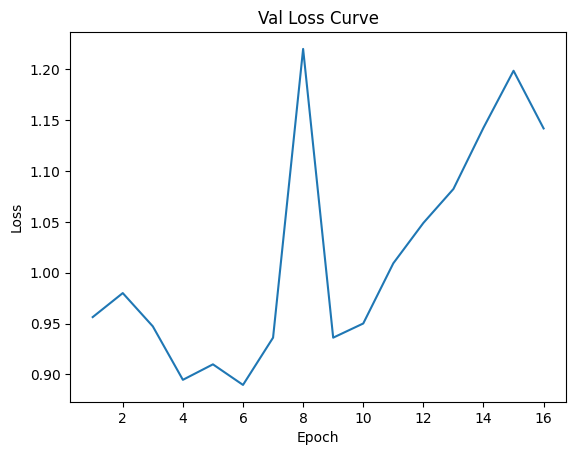

Student weights and architecture saved and exported for lambda: 0


In [27]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda0.pth'))
    teacher_model = teacher_model.to(device)
    
    # # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights=None)
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=0, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


In [28]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [31]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load teacher and student models for the current lambda
        teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes and inference times
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
        teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params,
                'teacher_time': teacher_time,
                'student_time': student_time
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params,
                'teacher_time': teacher_time,
                'student_time': student_time
            }


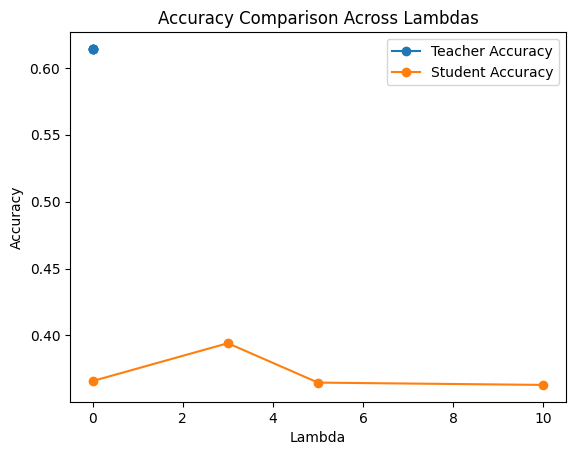

In [32]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


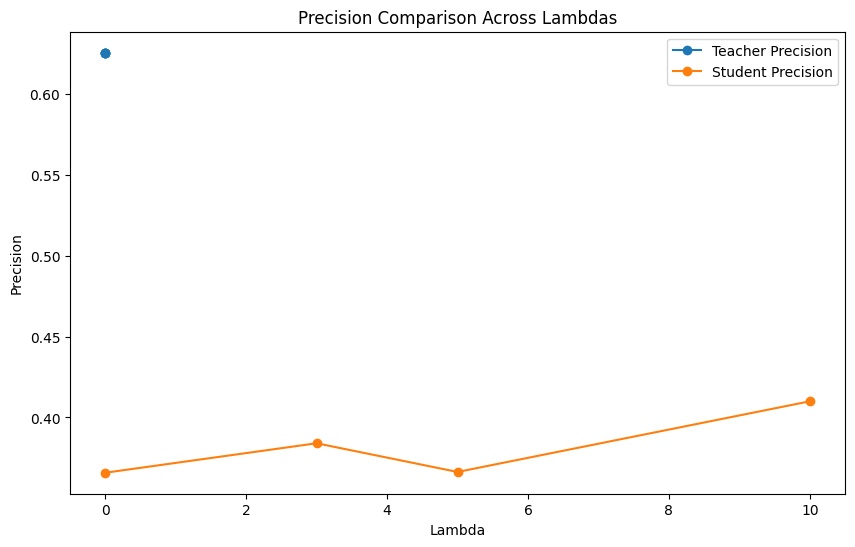

In [33]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


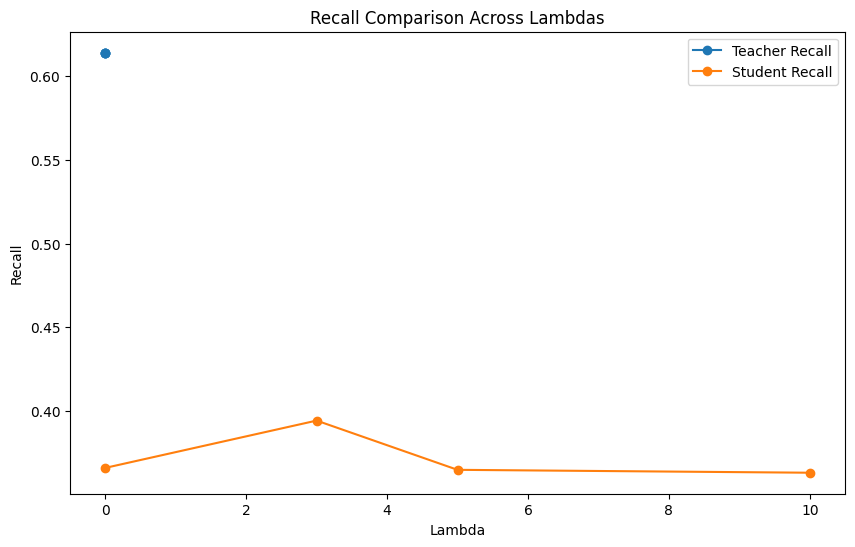

In [34]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


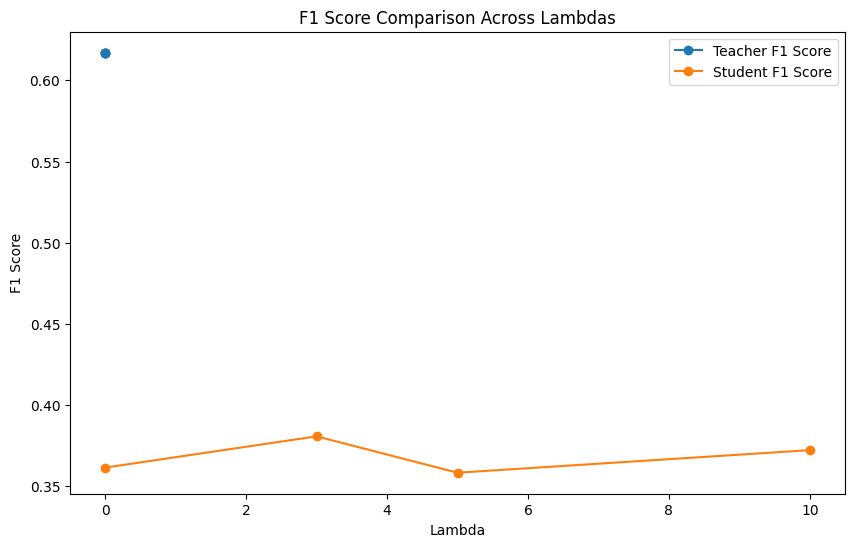

In [35]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


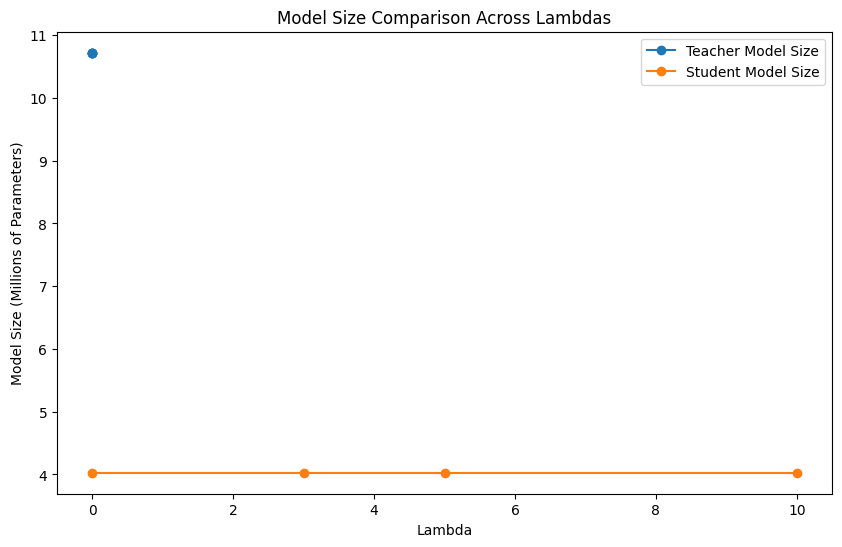

In [36]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


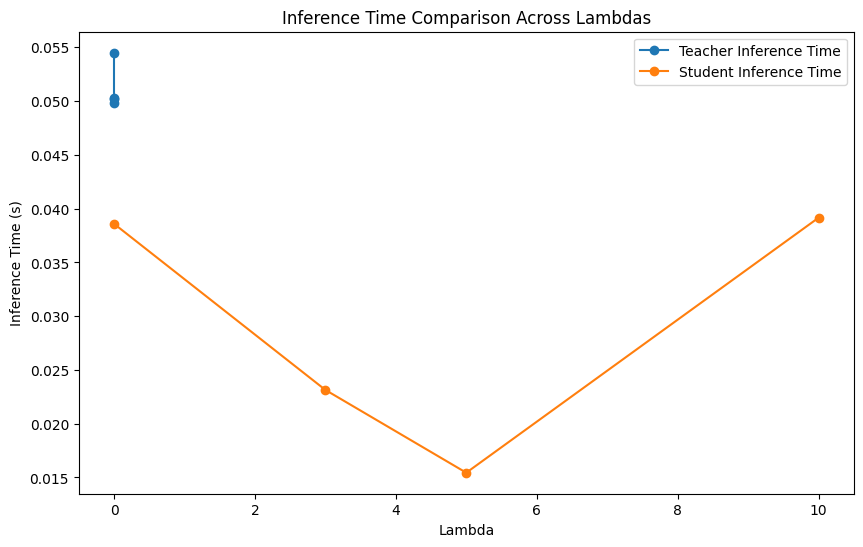

In [37]:
# Initialize lists to store inference times
teacher_times = []
student_times = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the inference times for each pair
        teacher_time = lambda_results[(lmda_teacher, lmda_student)]['teacher_time']
        student_time = lambda_results[(lmda_teacher, lmda_student)]['student_time']
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append inference times to the lists along with lambda values
    teacher_times.append((lmda_teacher, teacher_time))
    student_times.append((lmda_student, student_time))

# To plot, you might need to separate the lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times)
student_lambdas, student_inference_times = zip(*student_times)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


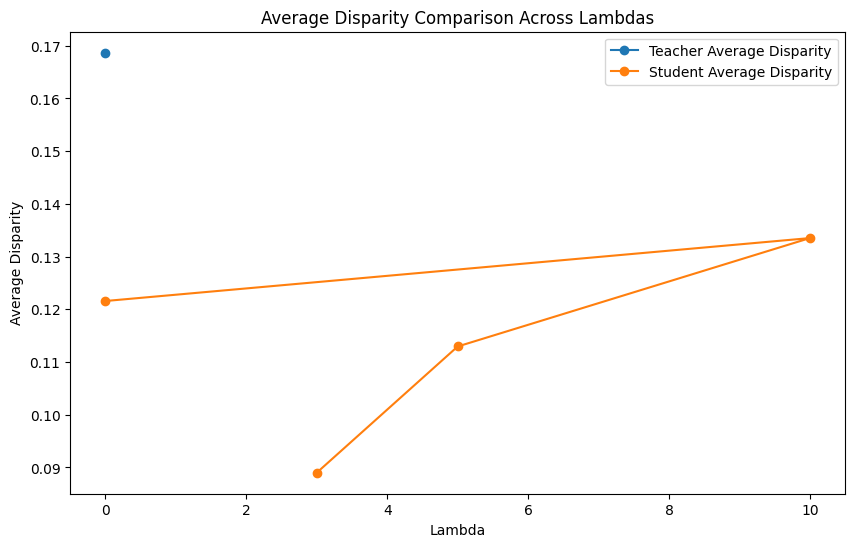

In [38]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


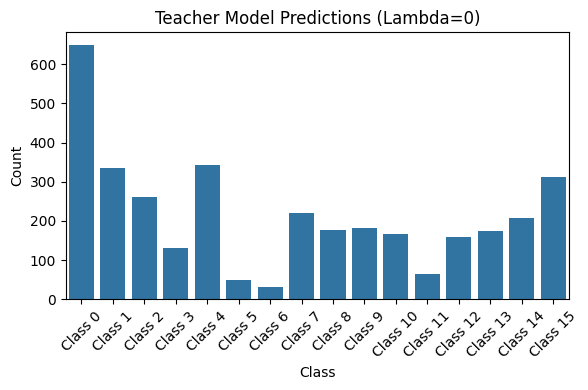

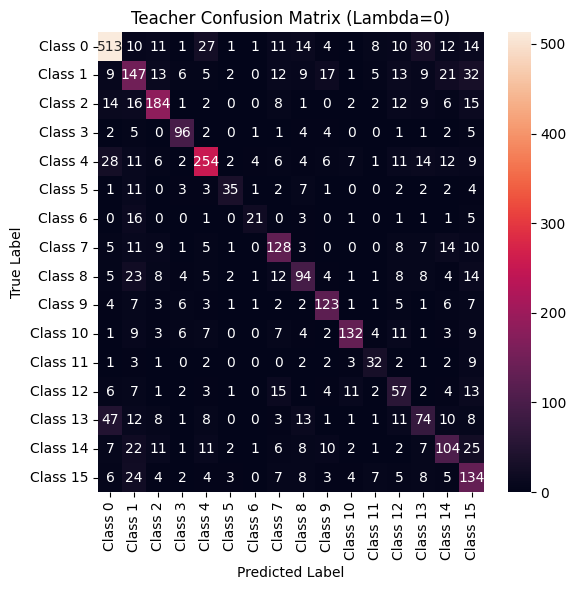

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.79      0.77      0.78       668
     Class 1       0.44      0.49      0.46       301
     Class 2       0.70      0.68      0.69       272
     Class 3       0.73      0.77      0.75       124
     Class 4       0.74      0.67      0.71       377
     Class 5       0.70      0.47      0.56        74
     Class 6       0.68      0.42      0.52        50
     Class 7       0.58      0.63      0.61       202
     Class 8       0.53      0.48      0.51       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.66      0.72       199
    Class 11       0.49      0.53      0.51        60
    Class 12       0.36      0.44      0.40       129
    Class 13       0.42      0.37      0.40       198
    Class 14       0.50      0.47      0.49       220
    Class 15       0.43      0.60      0.50       224

    accuracy                   

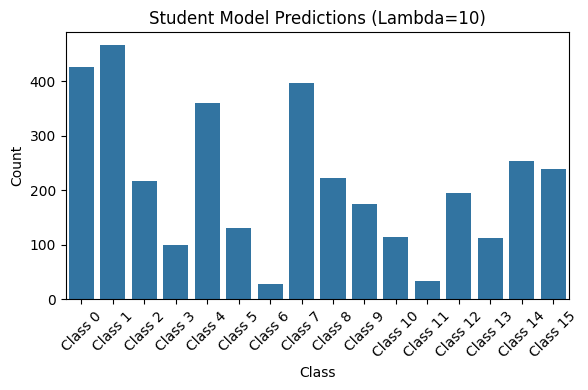

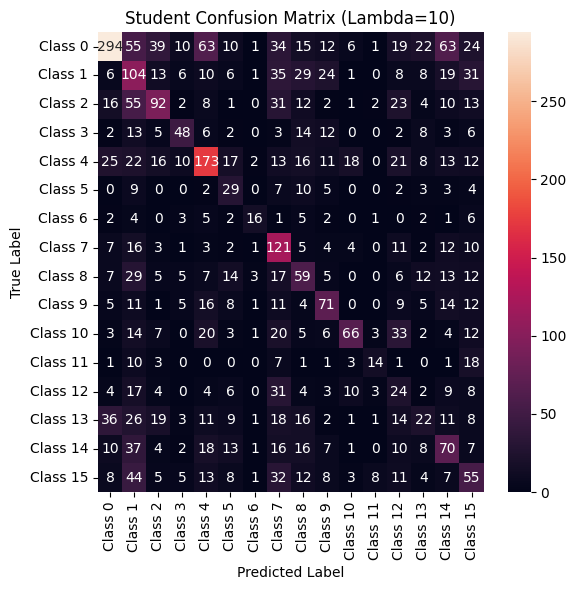

Classification Report - Student Model (Lambda=10)
              precision    recall  f1-score   support

     Class 0       0.69      0.44      0.54       668
     Class 1       0.22      0.35      0.27       301
     Class 2       0.43      0.34      0.38       272
     Class 3       0.48      0.39      0.43       124
     Class 4       0.48      0.46      0.47       377
     Class 5       0.22      0.39      0.28        74
     Class 6       0.55      0.32      0.41        50
     Class 7       0.30      0.60      0.40       202
     Class 8       0.26      0.30      0.28       194
     Class 9       0.41      0.41      0.41       173
    Class 10       0.58      0.33      0.42       199
    Class 11       0.42      0.23      0.30        60
    Class 12       0.12      0.19      0.15       129
    Class 13       0.20      0.11      0.14       198
    Class 14       0.28      0.32      0.30       220
    Class 15       0.23      0.25      0.24       224

    accuracy                  

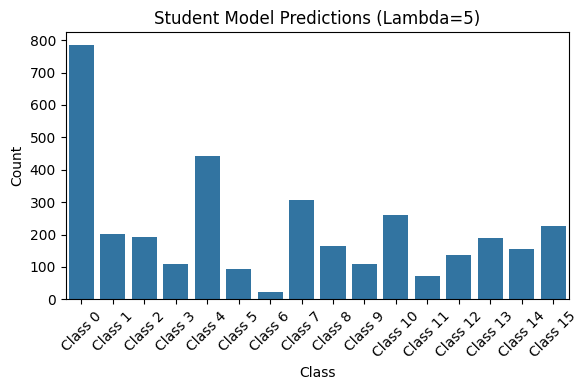

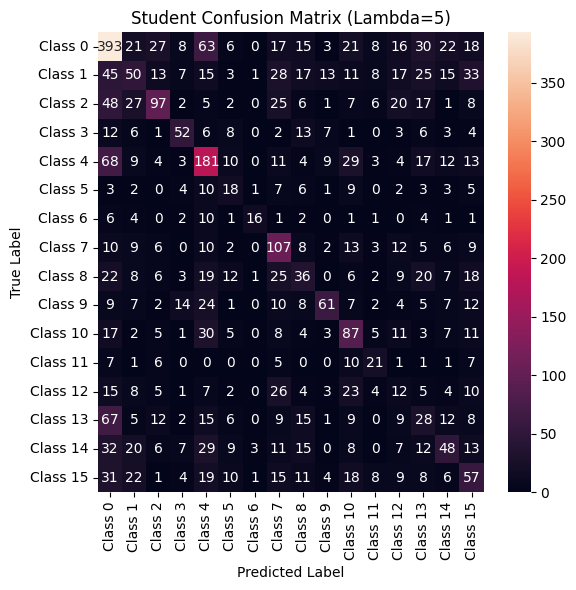

Classification Report - Student Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.50      0.59      0.54       668
     Class 1       0.25      0.17      0.20       301
     Class 2       0.51      0.36      0.42       272
     Class 3       0.47      0.42      0.44       124
     Class 4       0.41      0.48      0.44       377
     Class 5       0.19      0.24      0.21        74
     Class 6       0.70      0.32      0.44        50
     Class 7       0.35      0.53      0.42       202
     Class 8       0.22      0.19      0.20       194
     Class 9       0.56      0.35      0.43       173
    Class 10       0.33      0.44      0.38       199
    Class 11       0.30      0.35      0.32        60
    Class 12       0.09      0.09      0.09       129
    Class 13       0.15      0.14      0.14       198
    Class 14       0.31      0.22      0.26       220
    Class 15       0.25      0.25      0.25       224

    accuracy                   

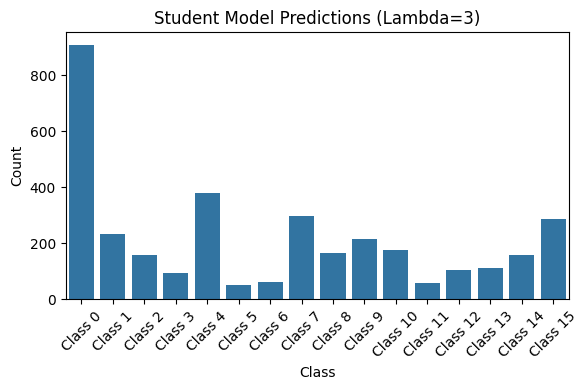

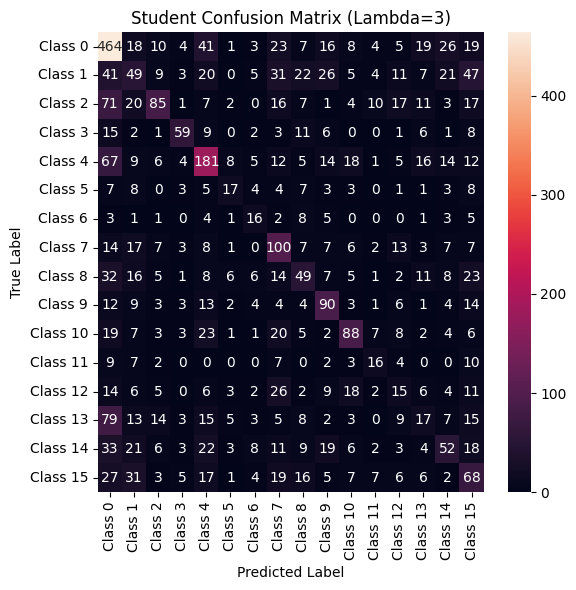

Classification Report - Student Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.51      0.69      0.59       668
     Class 1       0.21      0.16      0.18       301
     Class 2       0.53      0.31      0.39       272
     Class 3       0.62      0.48      0.54       124
     Class 4       0.48      0.48      0.48       377
     Class 5       0.33      0.23      0.27        74
     Class 6       0.25      0.32      0.28        50
     Class 7       0.34      0.50      0.40       202
     Class 8       0.29      0.25      0.27       194
     Class 9       0.42      0.52      0.47       173
    Class 10       0.50      0.44      0.47       199
    Class 11       0.28      0.27      0.27        60
    Class 12       0.14      0.12      0.13       129
    Class 13       0.15      0.09      0.11       198
    Class 14       0.33      0.24      0.27       220
    Class 15       0.24      0.30      0.27       224

    accuracy                   

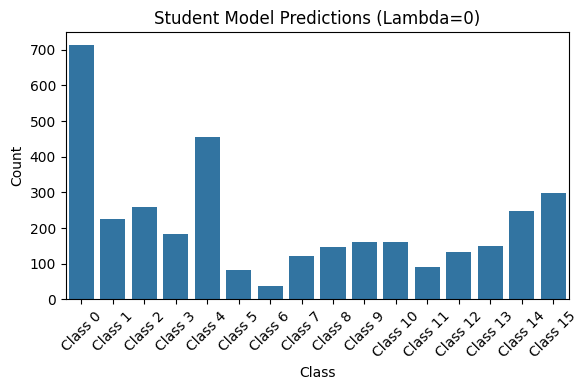

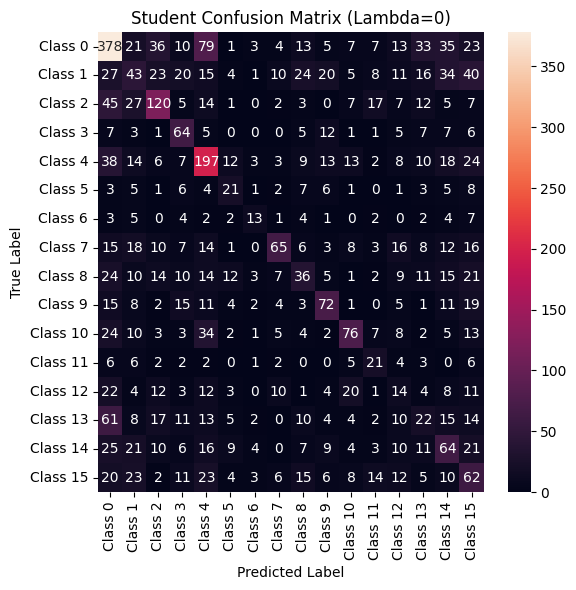

Classification Report - Student Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.53      0.57      0.55       668
     Class 1       0.19      0.14      0.16       301
     Class 2       0.46      0.44      0.45       272
     Class 3       0.35      0.52      0.42       124
     Class 4       0.43      0.52      0.47       377
     Class 5       0.26      0.28      0.27        74
     Class 6       0.35      0.26      0.30        50
     Class 7       0.54      0.32      0.40       202
     Class 8       0.24      0.19      0.21       194
     Class 9       0.44      0.42      0.43       173
    Class 10       0.47      0.38      0.42       199
    Class 11       0.23      0.35      0.28        60
    Class 12       0.11      0.11      0.11       129
    Class 13       0.15      0.11      0.13       198
    Class 14       0.26      0.29      0.27       220
    Class 15       0.21      0.28      0.24       224

    accuracy                   

In [39]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


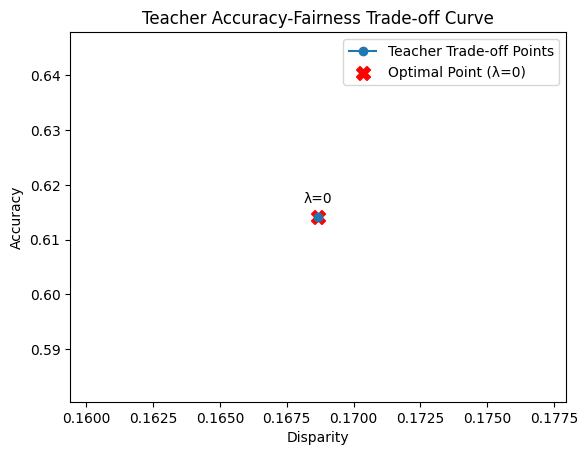

Optimal Lambda for Teacher: 0
Optimal Bias/Disparity for Teacher: 0.1686773766401768
Optimal Accuracy for Teacher: 0.6141414141414141
Optimal Weighted Ratio for Teacher: 0.53


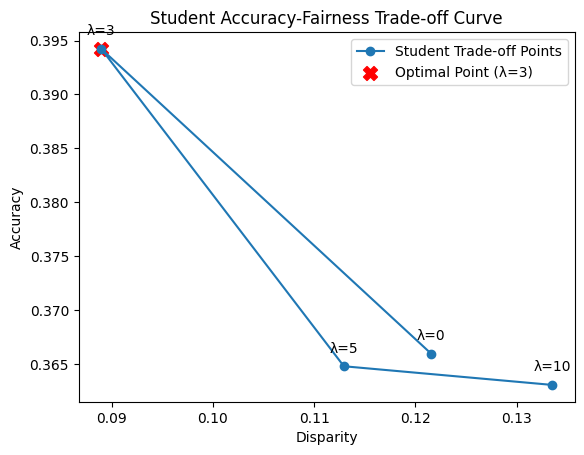

Optimal Lambda for Student: 3
Optimal Bias/Disparity for Student: 0.08899201443394761
Optimal Accuracy for Student: 0.3942279942279942
Optimal Weighted Ratio for Student: 0.36


In [40]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [41]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info



In [42]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


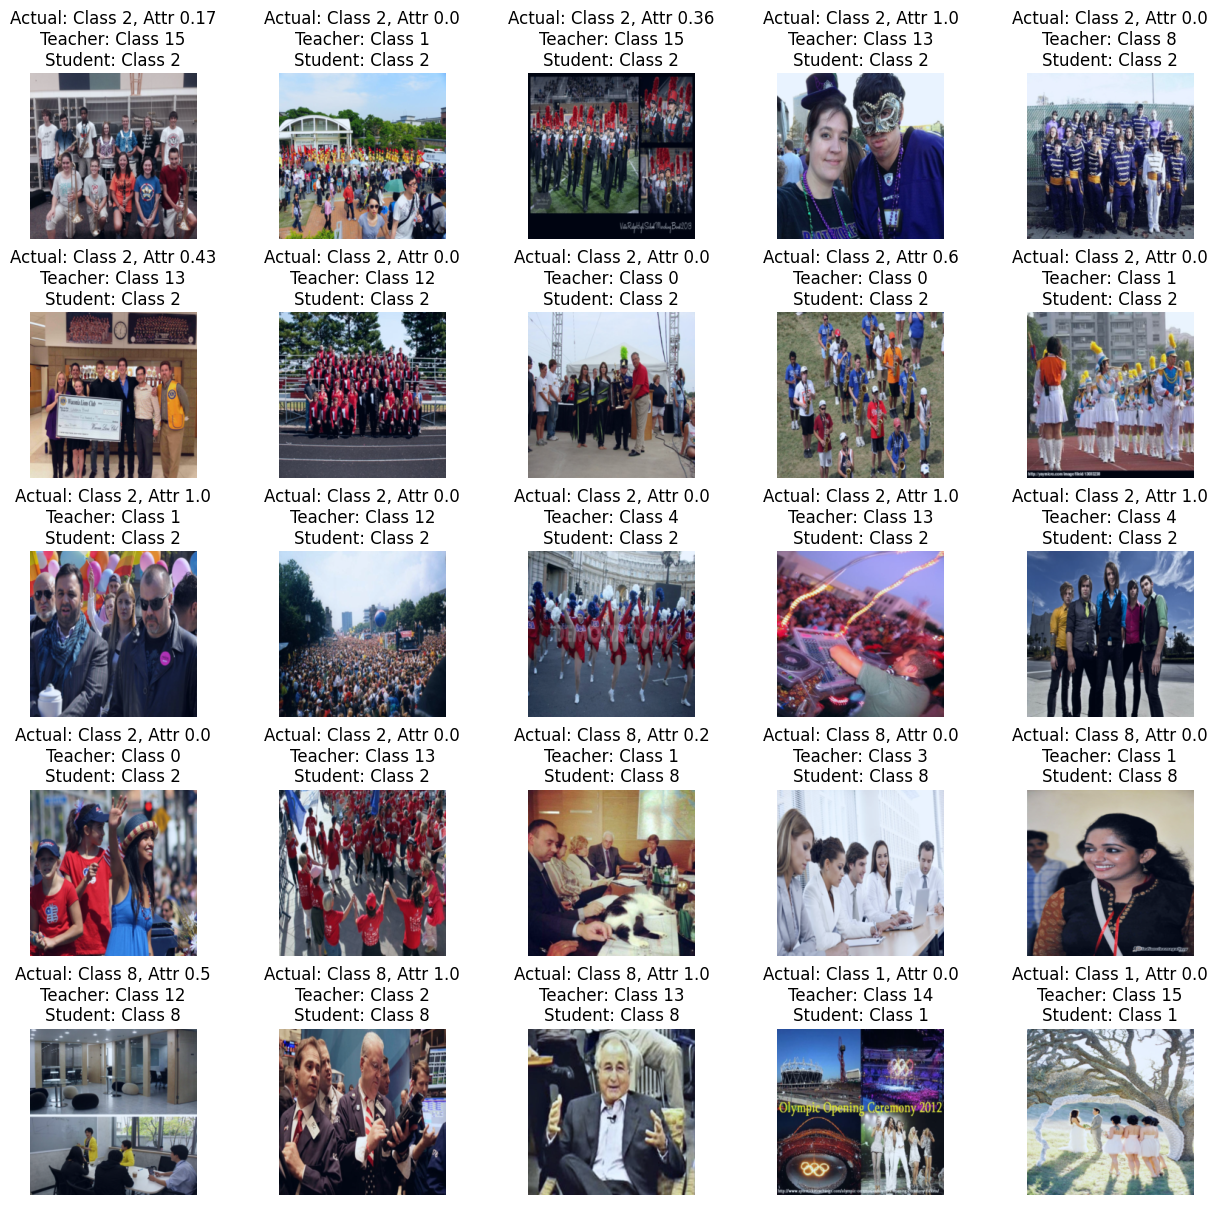

In [43]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)
